# Lego Market Value Prediction

## Overview
The objective of this project is to build a market value prediction model for Lego sets. There are two main data sources used in this project: BrickOwl - a Lego marketplace, and Rebrickable - a Lego set database. The BrickOwl dataset contains information about the value of Lego sets, while the Rebrickable dataset contains information about the characteristics of Lego sets. The goal is to predict the market value of Lego sets based on their characteristics. 

The project follows this framework:
1. Data Cleaning and Transformation
>- Data Cleaning
>- Data Merging
1. Exploratory Data Analysis
> Understanding the relationship between the target variable and the features
1. Feature Engineering
> Creating new features from existing ones
1. Data Preprocessing
>- Encoding categorical variables
>- Transforming numerical variables
>- Splitting the data into training and testing sets
1. Model Building
>- Tried different regression models
>- Evaluation using Cross-Validation
>- Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from currency_converter import CurrencyConverter

import missingno as msno

sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette('deep')

There are 44 columns in this dataset. We will need to reduce the number of variables in this dataset.

**Strategy**
> - Drop columns that are not relevant to our model.
>  - Consolidate `US/UK/CA/DE` of `_retailPrice`, `_dateFirstAvailable`, `_dateLastAvailable` into 3 columns.

## Brickset

In [6]:
brickset = pd.read_csv('brickset.csv')
brickset['set_number'] = brickset['number'] + '-' + brickset['numberVariant'].astype(str)
brickset.head()

,setID,number,numberVariant,name,year,theme,themeGroup,subtheme,category,released,...,CA_dateFirstAvailable,CA_dateLastAvailable,DE_retailPrice,DE_dateFirstAvailable,DE_dateLastAvailable,height,width,depth,weight,set_number
0,7693,1,8,Small house set,1970,Minitalia,Vintage,NaN,Normal,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-8
1,7695,2,8,Medium house set,1970,Minitalia,Vintage,NaN,Normal,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-8
2,7697,3,6,Medium house set,1970,Minitalia,Vintage,NaN,Normal,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3-6
3,7698,4,4,Large house set,1970,Minitalia,Vintage,NaN,Normal,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-4
4,25534,4,6,Mini House and Vehicles,1970,Samsonite,Vintage,Model Maker,Normal,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6


In [7]:
df = brickset

In [8]:
columns_to_drop = ['setID', 'number', 'numberVariant', 'bricksetURL', 'agerange_min', 'thumbnailURL', 'imageURL',
                   'height', 'width', 'depth', 'weight']

df.drop(columns=columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19409 entries, 0 to 19408
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   19409 non-null  object 
 1   year                   19409 non-null  int64  
 2   theme                  19409 non-null  object 
 3   themeGroup             19403 non-null  object 
 4   subtheme               15845 non-null  object 
 5   category               19409 non-null  object 
 6   released               19409 non-null  bool   
 7   pieces                 15277 non-null  float64
 8   minifigs               8869 non-null   float64
 9   rating                 19409 non-null  float64
 10  reviewCount            19409 non-null  int64  
 11  packagingType          19409 non-null  object 
 12  availability           19409 non-null  object 
 13  US_retailPrice         7483 non-null   float64
 14  US_dateFirstAvailable  7492 non-null   object 
 15  US

In [9]:
df[df['minifigs'] == df['minifigs'].max()]

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,UK_retailPrice,UK_dateFirstAvailable,UK_dateLastAvailable,CA_retailPrice,CA_dateFirstAvailable,CA_dateLastAvailable,DE_retailPrice,DE_dateFirstAvailable,DE_dateLastAvailable,set_number
885,Figure collection,1982,Fabuland,Junior,NaN,Normal,True,NaN,80.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3695-1


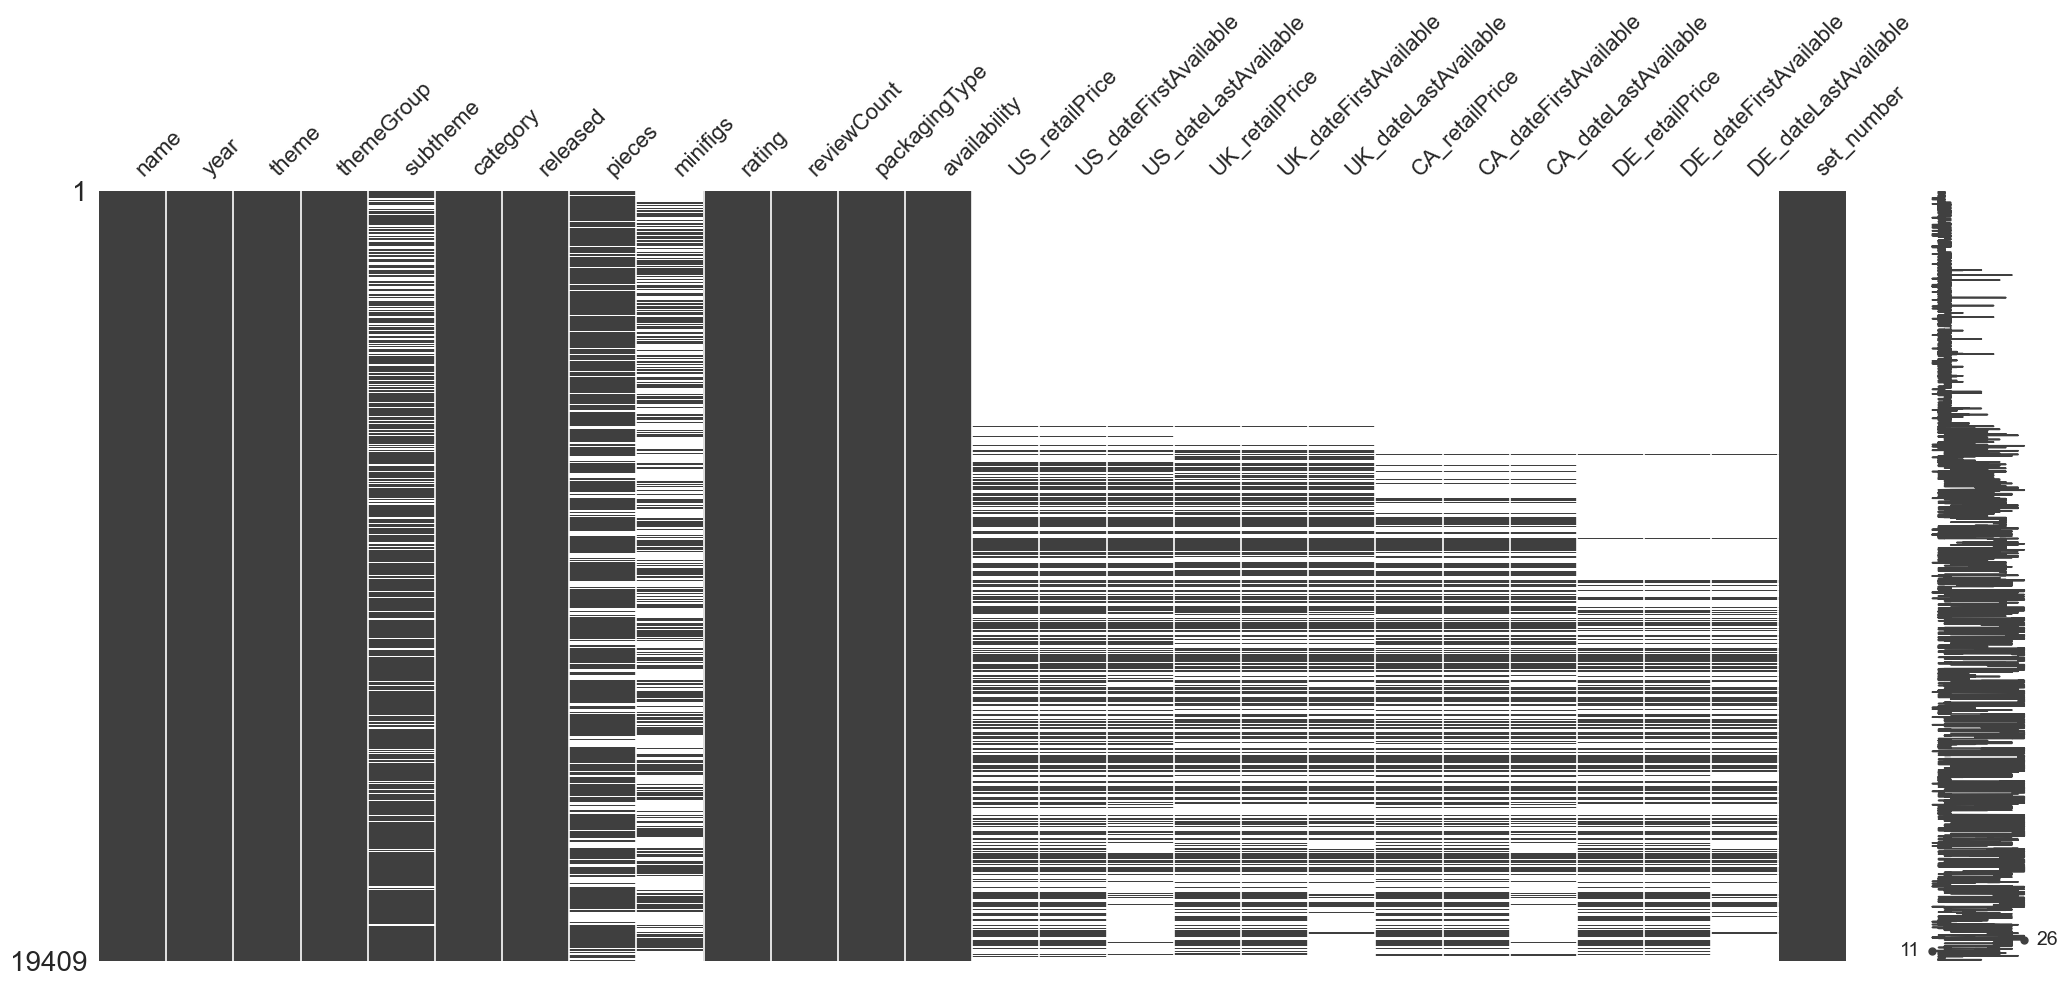

In [10]:
# Visualize missing values
msno.matrix(df)
plt.show()

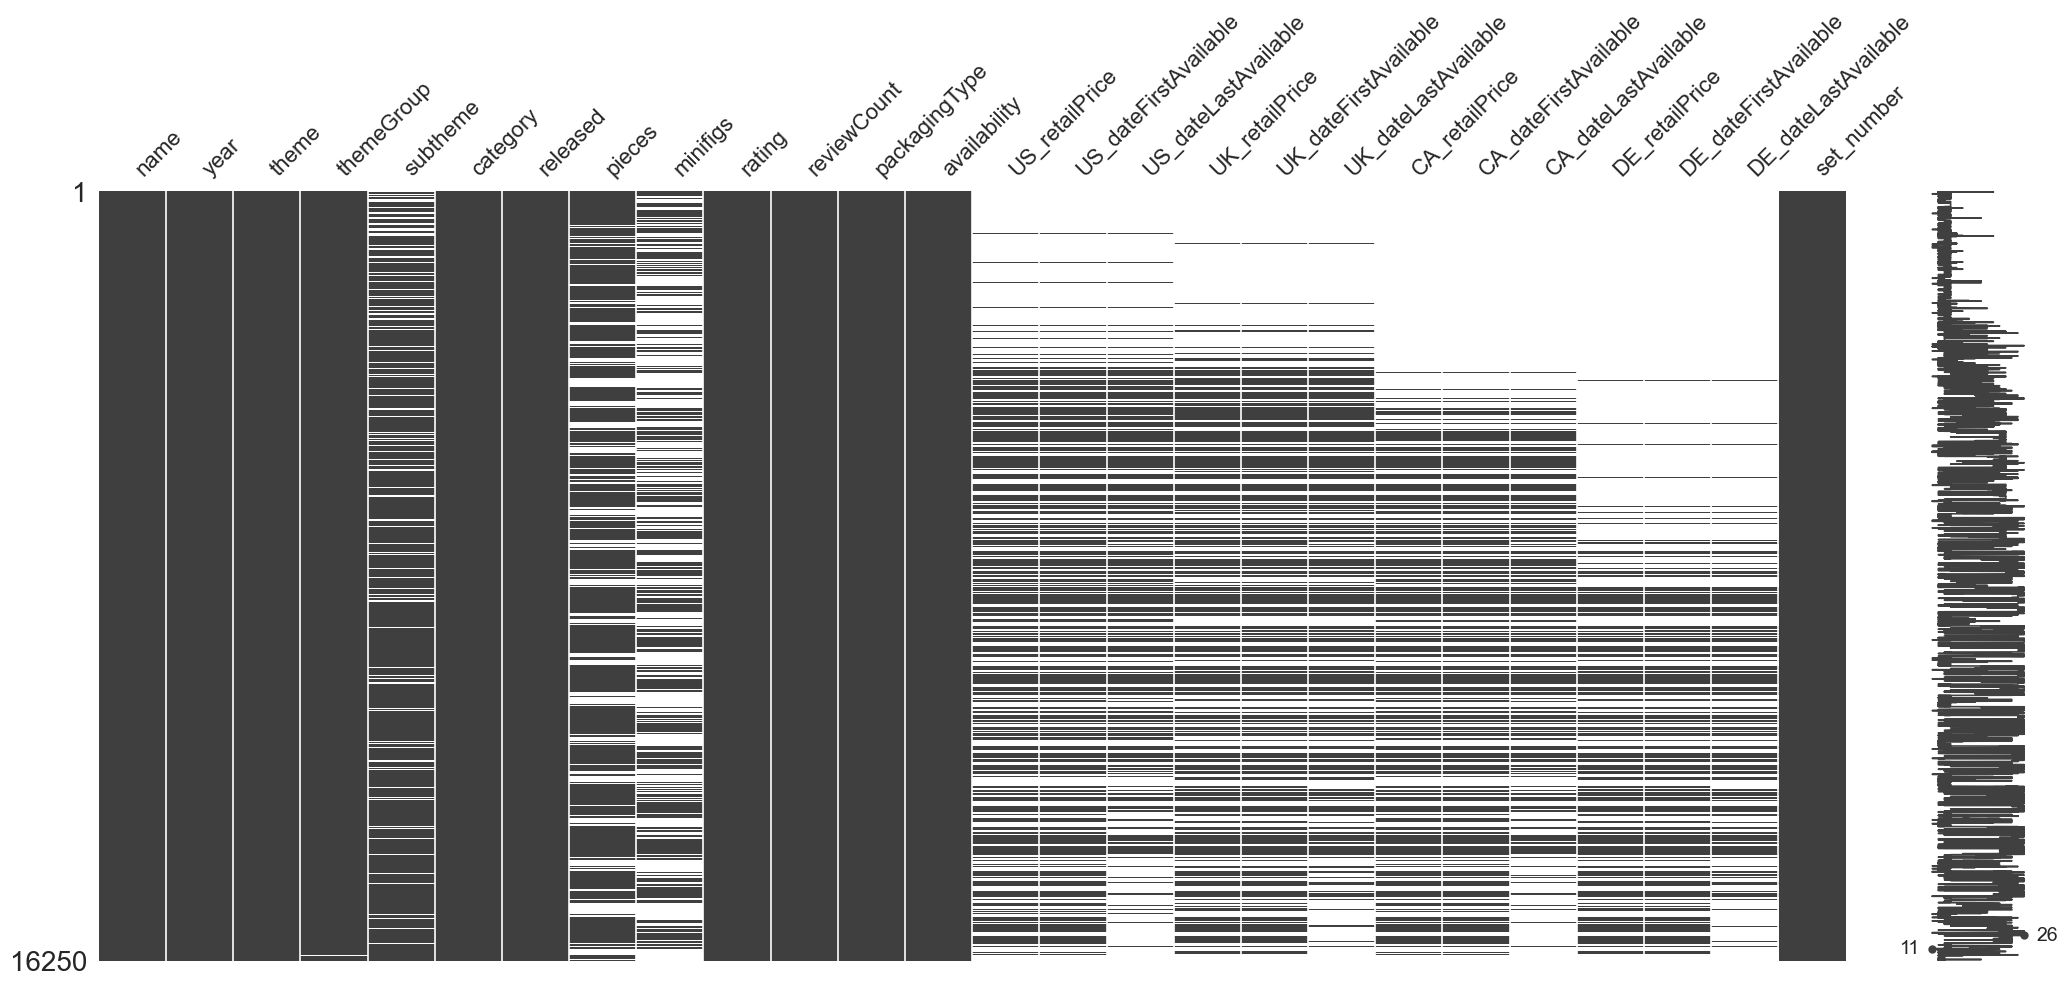

In [11]:
# Visualize missing values
msno.matrix(df[df['year'] > 1997])
plt.show()

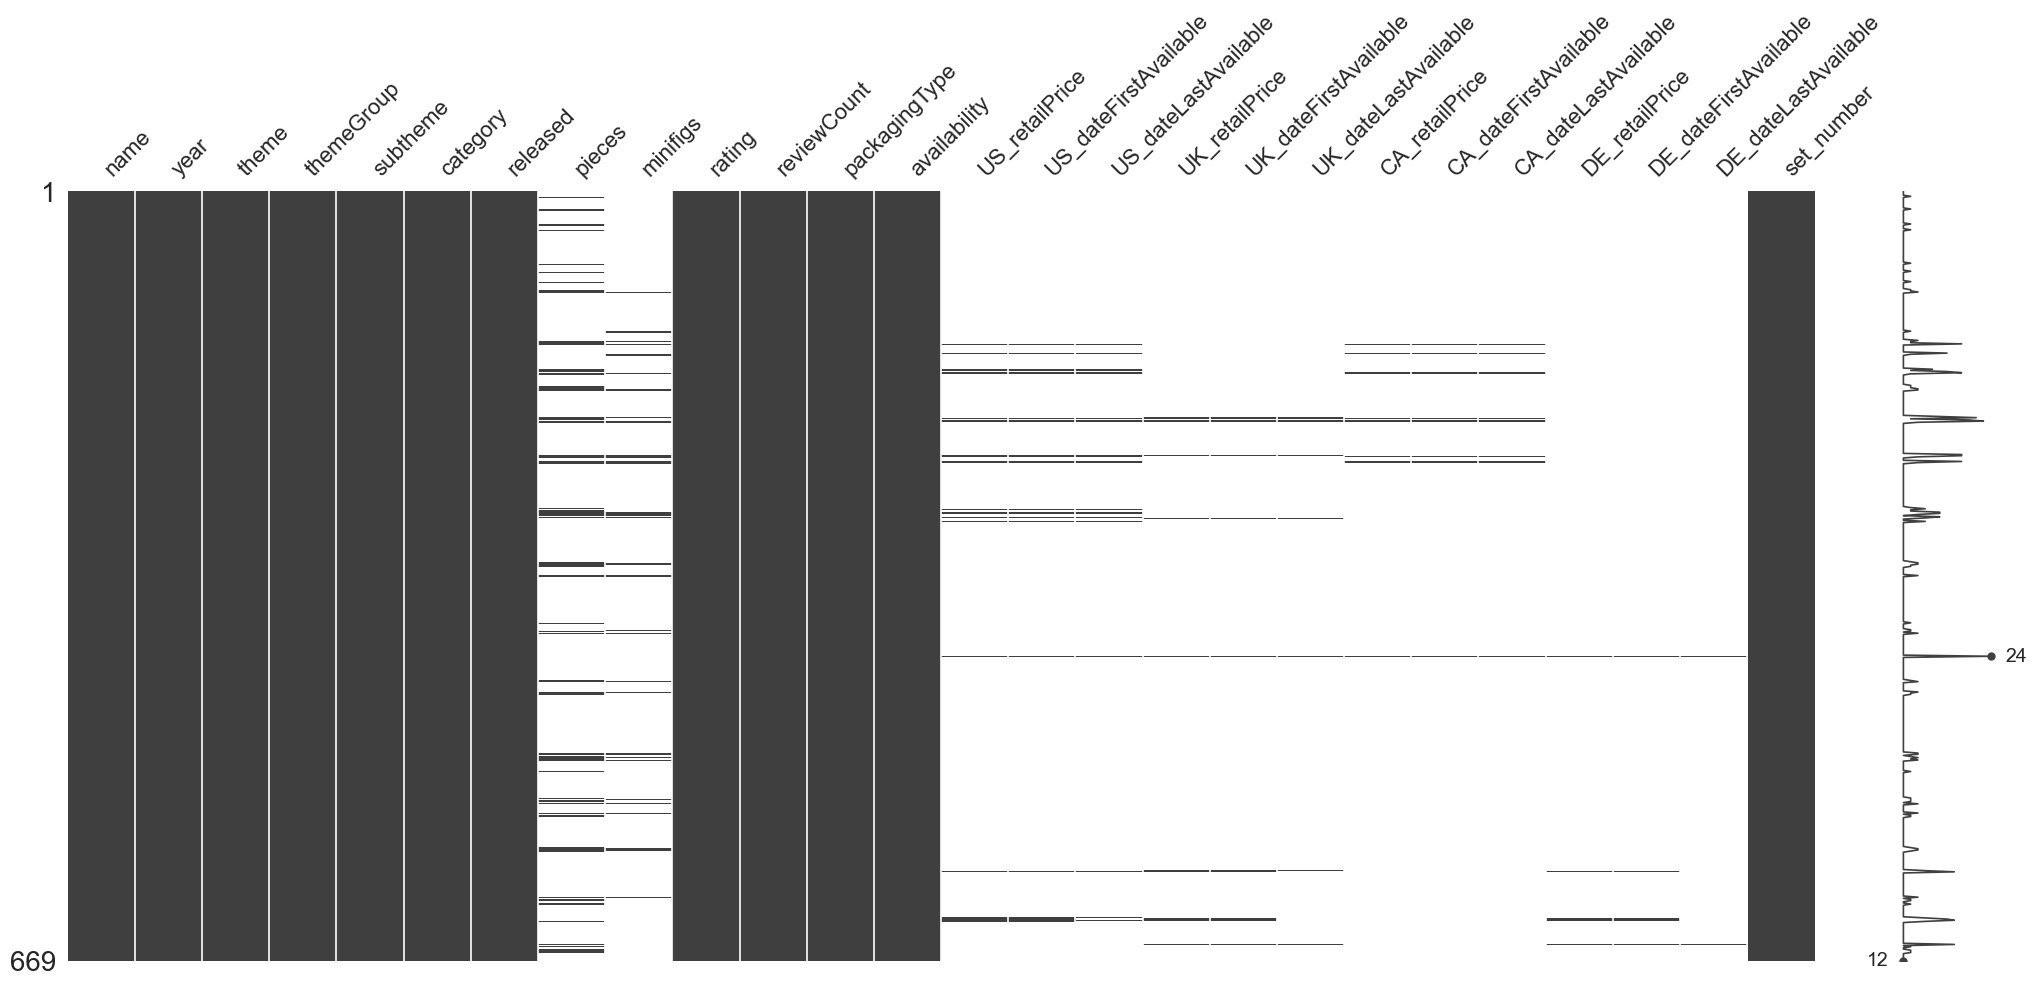

In [12]:
msno.matrix(df[df['theme'] == 'Books'])
plt.show()

In [13]:
df[df['theme'] == 'Books'].isna().sum()

name                       0
year                       0
theme                      0
themeGroup                 0
subtheme                   0
category                   0
released                   0
pieces                   587
minifigs                 632
rating                     0
reviewCount                0
packagingType              0
availability               0
US_retailPrice           647
US_dateFirstAvailable    647
US_dateLastAvailable     649
UK_retailPrice           657
UK_dateFirstAvailable    657
UK_dateLastAvailable     660
CA_retailPrice           659
CA_dateFirstAvailable    659
CA_dateLastAvailable     659
DE_retailPrice           664
DE_dateFirstAvailable    664
DE_dateLastAvailable     667
set_number                 0
dtype: int64

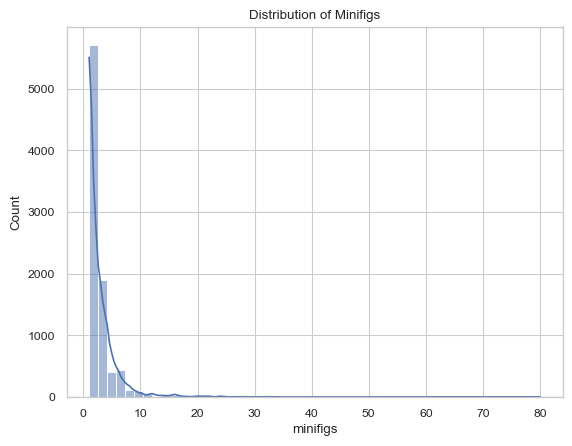

In [14]:
sns.histplot(df['minifigs'], bins=50, kde=True)
plt.title('Distribution of Minifigs');

In [15]:
df['category'].value_counts()

Normal        13289
Gear           2999
Other          1215
Book            669
Collection      609
Extended        558
Random           70
Name: category, dtype: int64

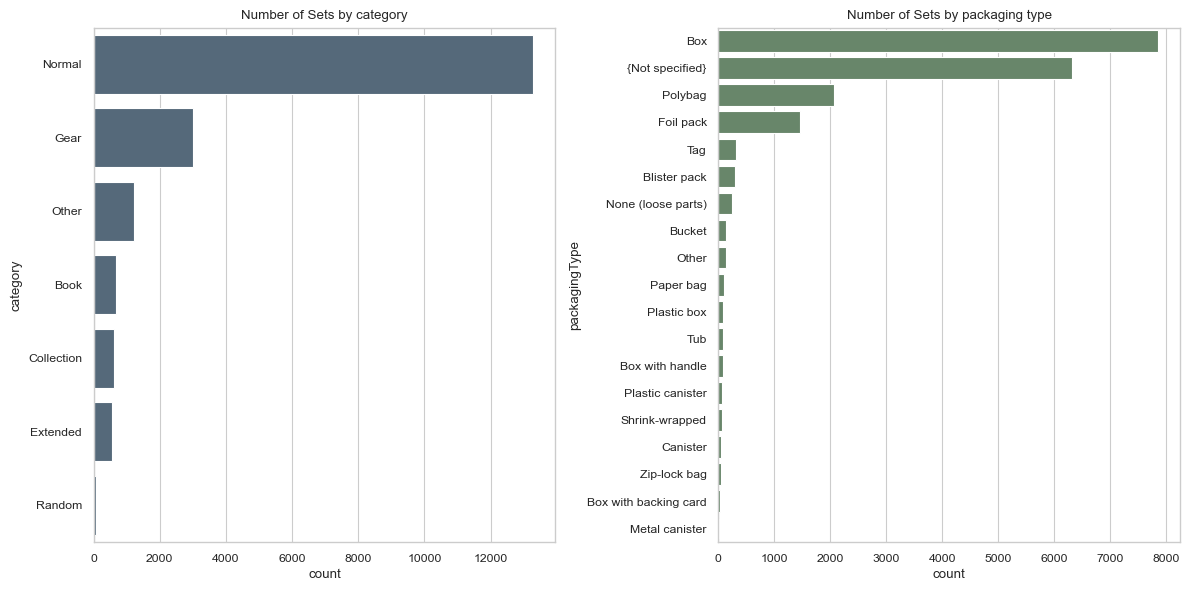

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(y='category', data=df, order=df['category'].value_counts().index, color='#4f6980', ax=ax[0])
ax[0].set_title('Number of Sets by category')

sns.countplot(y='packagingType', data=df, order=df['packagingType'].value_counts().index, color='#638b66', ax=ax[1])
ax[1].set_title('Number of Sets by packaging type')

plt.tight_layout()
plt.show()

In [17]:
df['subtheme'].value_counts()[df['subtheme'].value_counts() == 1]

Supplemental / 4.5V                 1
Magnets/Pirates of the Caribbean    1
Andor                               1
Jedi: Fallen Order                  1
Young Jedi Adventures               1
                                   ..
Square Fish                         1
Wonder Woman                        1
Key Chains/Rock Raiders             1
The Force Unleashed                 1
Galaxy's Edge                       1
Name: subtheme, Length: 99, dtype: int64

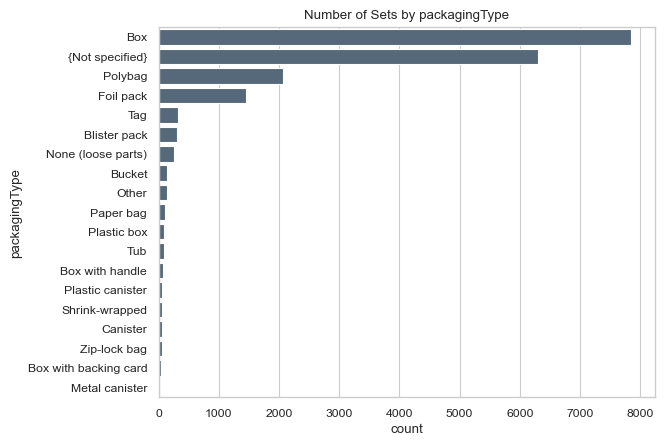

In [18]:
sns.countplot(y='packagingType', data=df, order=df['packagingType'].value_counts().index, color='#4f6980')
plt.title('Number of Sets by packagingType');

In [19]:
df['availability'].value_counts()

Retail                   7033
{Not specified}          6656
LEGO exclusive           2441
Retail - limited         1911
Promotional              1019
Educational               100
Not sold                   97
Promotional (Airline)      54
Unknown                    53
LEGOLAND exclusive         45
Name: availability, dtype: int64

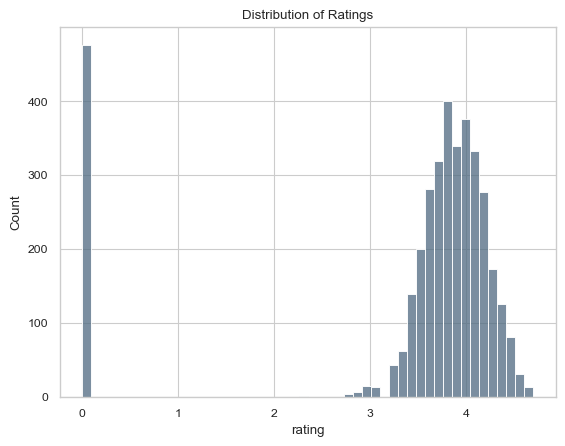

In [112]:
sns.histplot(df['rating'], bins=50, kde=False, color='#4f6980')
plt.title('Distribution of Ratings');

In [21]:
# Function to impute missing values across columns
def date_imputation(df, specify_string='First'):
    countries = ['UK', 'CA', 'DE']
    column_name = f'US_date{specify_string}Available'
    for country in countries:
        df[column_name] = df[column_name].fillna(df[f'{country}_date{specify_string}Available'])
    return df
date_imputation(df=df, specify_string='First')
date_imputation(df, specify_string='Last').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19409 entries, 0 to 19408
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   19409 non-null  object 
 1   year                   19409 non-null  int64  
 2   theme                  19409 non-null  object 
 3   themeGroup             19403 non-null  object 
 4   subtheme               15845 non-null  object 
 5   category               19409 non-null  object 
 6   released               19409 non-null  bool   
 7   pieces                 15277 non-null  float64
 8   minifigs               8869 non-null   float64
 9   rating                 19409 non-null  float64
 10  reviewCount            19409 non-null  int64  
 11  packagingType          19409 non-null  object 
 12  availability           19409 non-null  object 
 13  US_retailPrice         7483 non-null   float64
 14  US_dateFirstAvailable  8159 non-null   object 
 15  US

Now we have general columns `dateFirstAvailable`, `dateLastAvailable` we can safely drop the by country columns.

In [22]:
columns_to_drop = ['UK_dateFirstAvailable', 'UK_dateLastAvailable',
                     'CA_dateFirstAvailable', 'CA_dateLastAvailable', 'DE_dateFirstAvailable', 'DE_dateLastAvailable']
df.drop(columns=columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19409 entries, 0 to 19408
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   19409 non-null  object 
 1   year                   19409 non-null  int64  
 2   theme                  19409 non-null  object 
 3   themeGroup             19403 non-null  object 
 4   subtheme               15845 non-null  object 
 5   category               19409 non-null  object 
 6   released               19409 non-null  bool   
 7   pieces                 15277 non-null  float64
 8   minifigs               8869 non-null   float64
 9   rating                 19409 non-null  float64
 10  reviewCount            19409 non-null  int64  
 11  packagingType          19409 non-null  object 
 12  availability           19409 non-null  object 
 13  US_retailPrice         7483 non-null   float64
 14  US_dateFirstAvailable  8159 non-null   object 
 15  US

In [23]:
df.rename(columns={'US_dateFirstAvailable': 'dateFirstAvailable', 'US_dateLastAvailable': 'dateLastAvailable'}, inplace=True)

Retail Price
The exchange rate is retrieved from this [website](https://www.ofx.com/en-nz/forex-news/historical-exchange-rates/nzd/#)

In [24]:
usd_to_nzd = """December 31, 1990	1.678516
December 31, 1991	1.730307
December 31, 1992	1.859677
December 31, 1993	1.848755
December 31, 1994	1.686946
December 31, 1995	1.524352
December 31, 1996	1.454791
December 31, 1997	1.513903
December 31, 1998	1.87044
December 31, 1999	1.889743
December 31, 2000	2.206312
December 31, 2001	2.380208
December 31, 2002	2.169132
December 31, 2003	1.717178
December 31, 2004	1.509313
December 31, 2005	1.420183
December 31, 2006	1.541817
December 31, 2007	1.361063
December 31, 2008	1.422352
December 31, 2009	1.598567
December 31, 2010	1.387655
December 31, 2011	1.264412
December 31, 2012	1.234992
December 31, 2013	1.219952
December 31, 2014	1.205947
December 31, 2015	1.434907
December 31, 2016	1.436486
December 31, 2017	1.407195
December 31, 2018	1.446757
December 31, 2019	1.518486
December 31, 2020	1.539814
December 31, 2021	1.415139
December 31, 2022	1.578432
December 31, 2023	1.629604
September 3, 2024	1.644323"""

cad_to_nzd = """December 31, 1990	1.438579
December 31, 1991	1.510126
December 31, 1992	1.539433
December 31, 1993	1.43417
December 31, 1994	1.235158
December 31, 1995	1.110766
December 31, 1996	1.066676
December 31, 1997	1.092664
December 31, 1998	1.260551
December 31, 1999	1.272146
December 31, 2000	1.484038
December 31, 2001	1.537537
December 31, 2002	1.380314
December 31, 2003	1.230933
December 31, 2004	1.160664
December 31, 2005	1.174147
December 31, 2006	1.359896
December 31, 2007	1.269972
December 31, 2008	1.329315
December 31, 2009	1.395493
December 31, 2010	1.346408
December 31, 2011	1.279563
December 31, 2012	1.23506
December 31, 2013	1.184555
December 31, 2014	1.091712
December 31, 2015	1.121196
December 31, 2016	1.08402
December 31, 2017	1.084999
December 31, 2018	1.115657
December 31, 2019	1.144254
December 31, 2020	1.148077
December 31, 2021	1.12869
December 31, 2022	1.211905
December 31, 2023	1.207084
September 3, 2024	1.207959"""

eur_to_nzd = """December 31, 1999	2.013608
December 31, 2000	2.029214
December 31, 2001	2.131417
December 31, 2002	2.037998
December 31, 2003	1.943715
December 31, 2004	1.875275
December 31, 2005	1.768822
December 31, 2006	1.936895
December 31, 2007	1.862965
December 31, 2008	2.075156
December 31, 2009	2.215078
December 31, 2010	1.840415
December 31, 2011	1.760247
December 31, 2012	1.587952
December 31, 2013	1.620806
December 31, 2014	1.600525
December 31, 2015	1.59184
December 31, 2016	1.589443
December 31, 2017	1.589912
December 31, 2018	1.70682
December 31, 2019	1.699939
December 31, 2020	1.756197
December 31, 2021	1.673773
December 31, 2022	1.658977
December 31, 2023	1.763307
September 3, 2024	1.783534"""

gbp_to_nzd = """December 31, 1990	2.990532
December 31, 1991	3.056055
December 31, 1992	3.281403
December 31, 1993	2.775812
December 31, 1994	2.582027
December 31, 1995	2.405835
December 31, 1996	2.269374
December 31, 1997	2.479657
December 31, 1998	3.100375
December 31, 1999	3.056984
December 31, 2000	3.330941
December 31, 2001	3.426887
December 31, 2002	3.245956
December 31, 2003	2.804606
December 31, 2004	2.7644
December 31, 2005	2.583407
December 31, 2006	2.84045
December 31, 2007	2.722479
December 31, 2008	2.605228
December 31, 2009	2.485331
December 31, 2010	2.143455
December 31, 2011	2.028974
December 31, 2012	1.95673
December 31, 2013	1.908724
December 31, 2014	1.984974
December 31, 2015	2.194078
December 31, 2016	1.950343
December 31, 2017	1.813327
December 31, 2018	1.928756
December 31, 2019	1.937851
December 31, 2020	1.974058
December 31, 2021	1.946284
December 31, 2022	1.945935
December 31, 2023	2.026784
September 3, 2024	2.090886"""

In [25]:
def get_exchange_rate(a_string):
    exchange_rate = {}
    for line in a_string.split('\n'):
        date, rate = line.split('\t')
        exchange_rate[date[-4:]] = float(rate)
    return exchange_rate

In [26]:
usd = get_exchange_rate(usd_to_nzd)
can = get_exchange_rate(cad_to_nzd)
eur = get_exchange_rate(eur_to_nzd)
gbp = get_exchange_rate(gbp_to_nzd)

In [27]:
def change_rate_to_nzd(row, exchange_rate, col_name):
    years = np.array(list(exchange_rate.keys())).astype(int)
    if row['year'] < min(years): # if year is before the earliest year avaiable then use earliest year
        return row[col_name] * exchange_rate[min(exchange_rate.keys())] 
    else:
        return row[col_name] * exchange_rate[str(row['year'])]

In [28]:
df['us_converted'] = df.apply(change_rate_to_nzd, exchange_rate=usd, col_name='US_retailPrice', axis=1)
df['ca_converted'] = df.apply(change_rate_to_nzd, exchange_rate=can, col_name='CA_retailPrice', axis=1)
df['de_converted'] = df.apply(change_rate_to_nzd, exchange_rate=eur, col_name='DE_retailPrice', axis=1)
df['uk_converted'] = df.apply(change_rate_to_nzd, exchange_rate=gbp, col_name='UK_retailPrice', axis=1)

In [29]:
df.drop(['UK_retailPrice', 'CA_retailPrice', 'DE_retailPrice', 'US_retailPrice'], axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19409 entries, 0 to 19408
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                19409 non-null  object 
 1   year                19409 non-null  int64  
 2   theme               19409 non-null  object 
 3   themeGroup          19403 non-null  object 
 4   subtheme            15845 non-null  object 
 5   category            19409 non-null  object 
 6   released            19409 non-null  bool   
 7   pieces              15277 non-null  float64
 8   minifigs            8869 non-null   float64
 9   rating              19409 non-null  float64
 10  reviewCount         19409 non-null  int64  
 11  packagingType       19409 non-null  object 
 12  availability        19409 non-null  object 
 13  dateFirstAvailable  8159 non-null   object 
 14  dateLastAvailable   7289 non-null   object 
 15  set_number          19409 non-null  object 
 16  us_c

Now we want to impute any missing values across the retail price columns.

In [31]:
df['us_converted'] = df['us_converted'].fillna(df['ca_converted'])
df['us_converted'] = df['us_converted'].fillna(df['de_converted'])
df['us_converted'] = df['us_converted'].fillna(df['uk_converted'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19409 entries, 0 to 19408
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                19409 non-null  object 
 1   year                19409 non-null  int64  
 2   theme               19409 non-null  object 
 3   themeGroup          19403 non-null  object 
 4   subtheme            15845 non-null  object 
 5   category            19409 non-null  object 
 6   released            19409 non-null  bool   
 7   pieces              15277 non-null  float64
 8   minifigs            8869 non-null   float64
 9   rating              19409 non-null  float64
 10  reviewCount         19409 non-null  int64  
 11  packagingType       19409 non-null  object 
 12  availability        19409 non-null  object 
 13  dateFirstAvailable  8159 non-null   object 
 14  dateLastAvailable   7289 non-null   object 
 15  set_number          19409 non-null  object 
 16  us_c

In [33]:
df.drop(['ca_converted', 'de_converted', 'uk_converted'], axis=1, inplace=True)
df.rename(columns={'us_converted': 'NZ_retailPrice'}, inplace=True)

In [34]:
df[df['NZ_retailPrice'] ==  df['NZ_retailPrice'].max()]

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice
17073,AT-AT,2021,Star Wars,Licensed,Ultimate Collector Series,Normal,True,6785.0,9.0,4.5,5,Box,LEGO exclusive,2021-12-05,NaN,75313-1,1202.853999


### Connecting the Data Sources
Data sources:
- Brick Owl: contains the current market value of the sets.
- Brickset: contains information about sets such as availability, number of pieces, etc.

We will join the two data frame on `set_number` and `number`

In [35]:
brickowl = pd.read_csv('brick_owl/brickowl_final.csv')
brickowl_small = brickowl[-brickowl['mean_nzd_new'].isnull()][['set_number', 'mean_nzd_new']]
df = pd.merge(df, brickowl_small, on='set_number', how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7777 entries, 0 to 7776
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                7777 non-null   object 
 1   year                7777 non-null   int64  
 2   theme               7777 non-null   object 
 3   themeGroup          7773 non-null   object 
 4   subtheme            6862 non-null   object 
 5   category            7777 non-null   object 
 6   released            7777 non-null   bool   
 7   pieces              7620 non-null   float64
 8   minifigs            5220 non-null   float64
 9   rating              7777 non-null   float64
 10  reviewCount         7777 non-null   int64  
 11  packagingType       7777 non-null   object 
 12  availability        7777 non-null   object 
 13  dateFirstAvailable  4337 non-null   object 
 14  dateLastAvailable   3835 non-null   object 
 15  set_number          7777 non-null   object 
 16  NZ_ret

Save the cleaned data to a new csv file.

In [36]:
df.to_csv('bricksetowl.csv', index=False)

In [37]:
df = pd.read_csv('bricksetowl.csv')
df.head()

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new
0,Taxi,1971,LEGOLAND,Vintage,Vehicle,Normal,True,19.0,NaN,0.0,1,Box,Retail,NaN,NaN,605-2,NaN,105.829737
1,Articulated Lorry,1971,LEGOLAND,Vintage,Vehicle,Normal,True,58.0,NaN,0.0,0,{Not specified},{Not specified},NaN,NaN,683-1,NaN,540.334429
2,Low-Loader Truck with Forklift,1972,LEGOLAND,Vintage,Vehicle,Normal,True,53.0,NaN,0.0,1,{Not specified},{Not specified},NaN,NaN,684-1,NaN,419.292288
3,Basic Set,1973,Universal Building Set,Basic,NaN,Normal,True,184.0,NaN,0.0,1,{Not specified},{Not specified},NaN,NaN,3-4,NaN,342.019044
4,Basic Set,1973,Universal Building Set,Basic,NaN,Normal,True,415.0,NaN,0.0,0,{Not specified},{Not specified},NaN,NaN,7-3,NaN,209.542879


### Missing Data

In [38]:
# Function to display missing values
def missing_values(df):
    for col in df.columns:
        null_percentage = df[col].isnull().sum() / df.shape[0] * 100
        if null_percentage > 0:
            print(f"{col}: {null_percentage:.2f}%")

In [39]:
missing_values(df)

themeGroup: 0.05%
subtheme: 11.77%
pieces: 2.02%
minifigs: 32.88%
dateFirstAvailable: 44.23%
dateLastAvailable: 50.69%
NZ_retailPrice: 44.27%


There are 7 columns containing missing data.

**Innitial Strategy**:
- `themeGroup`: fill with *"Unknown"*
- `subtheme`: fill with *"Unknown"*
- `pieces`: get more data from Brickeconomy and fill the missing values.
- `NZ_retailPrice`: Build a linear model to predict the missing values.
- `dateFirstAvailable` and `dateLastAvailable`: Combine them into `lifespan` and fill the missing values with the median.

#### Days_since_retired

In [40]:
df['dateLastAvailable'] = pd.to_datetime(df['dateLastAvailable'])
df['dateFirstAvailable'] = pd.to_datetime(df['dateFirstAvailable'])

In [41]:
from datetime import date, datetime

In [42]:
date_collected = date(2024, 8, 20) # The day data was collected
date_collected = datetime.combine(date_collected, datetime.min.time()) # Convert date_collected to datetime object for comparison

df['days_since_last_available'] = (date_collected - df['dateLastAvailable']).dt.days

In [43]:
df['days_since_last_available'].describe()

count    3835.000000
mean     2344.743937
std      1576.676248
min       223.000000
25%      1008.000000
50%      2082.000000
75%      3481.000000
max      6136.000000
Name: days_since_last_available, dtype: float64

<AxesSubplot: xlabel='days_since_last_available', ylabel='Count'>

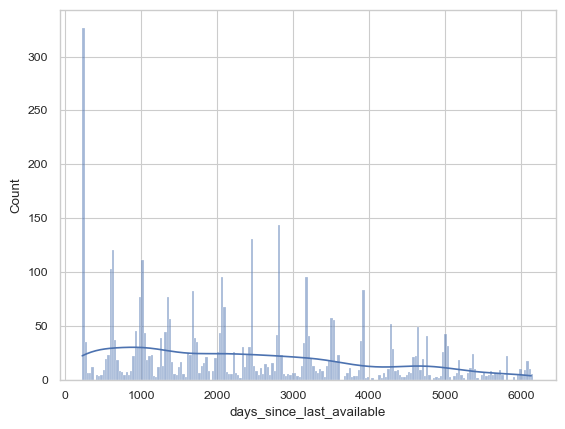

In [44]:
sns.histplot(df['days_since_last_available'], bins=20, kde=True, binwidth=30)

There is a clear partern of the distribution of `days_since_last_available`. 

#### Life Span

In [45]:
df['lifespan'] = df['dateLastAvailable'] - df['dateFirstAvailable']

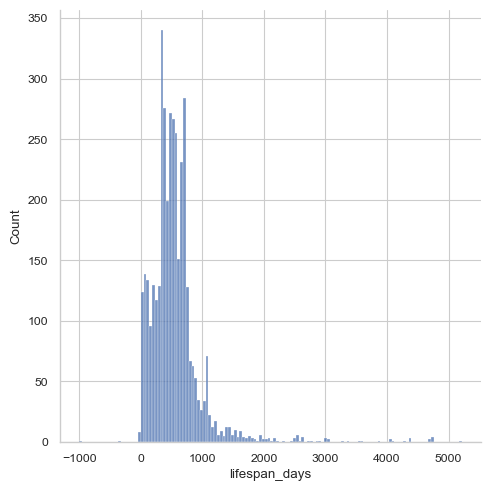

In [46]:
df['lifespan_days'] = df['lifespan'].dt.days
sns.displot(df['lifespan_days'], kde=False)

Most of the values for lifespan are around 0 to 1000 days. With some outliers having 3k to 5k days.

We will also need to investigate the negative values in the lifespan column which is not possible to have negative values.

In [47]:
df[df['lifespan_days'] < 0]

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,packagingType,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan,lifespan_days
4758,Easter Bunny Hut,2018,Seasonal,Miscellaneous,Easter,Extended,True,6.0,1.0,3.5,...,Box,LEGO exclusive,2020-10-28,2019-11-23,5005249-1,8.666074,11.422850,1732.0,-340 days,-340.0
5387,Train,2020,Creator,Model making,Miscellaneous,Normal,True,59.0,NaN,3.8,...,Polybag,{Not specified},2023-12-05,2021-03-04,30575-1,7.683672,15.321316,1265.0,-1006 days,-1006.0


A browse through the brickset website and also looking at the `year` columns we can see that they are mistake in the `dateFirstAvailable`.

We will extract the date and month from `dateFirstAvailable` then combined with the `year` column to get the correct date.

In [48]:
subset = df[df['lifespan_days'] < 0]
subset

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,packagingType,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan,lifespan_days
4758,Easter Bunny Hut,2018,Seasonal,Miscellaneous,Easter,Extended,True,6.0,1.0,3.5,...,Box,LEGO exclusive,2020-10-28,2019-11-23,5005249-1,8.666074,11.422850,1732.0,-340 days,-340.0
5387,Train,2020,Creator,Model making,Miscellaneous,Normal,True,59.0,NaN,3.8,...,Polybag,{Not specified},2023-12-05,2021-03-04,30575-1,7.683672,15.321316,1265.0,-1006 days,-1006.0


In [49]:
for i in subset.index:
    day = subset.loc[i, 'dateFirstAvailable'].day
    month = subset.loc[i, 'dateFirstAvailable'].month
    full = str(subset.loc[i, 'year']) + '-' + str(month) + '-' + str(day)
    df.loc[i, 'dateFirstAvailable'] = pd.to_datetime(full)
df

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,packagingType,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan,lifespan_days
0,Taxi,1971,LEGOLAND,Vintage,Vehicle,Normal,True,19.0,NaN,0.0,...,Box,Retail,NaT,NaT,605-2,NaN,105.829737,NaN,NaT,NaN
1,Articulated Lorry,1971,LEGOLAND,Vintage,Vehicle,Normal,True,58.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,683-1,NaN,540.334429,NaN,NaT,NaN
2,Low-Loader Truck with Forklift,1972,LEGOLAND,Vintage,Vehicle,Normal,True,53.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,684-1,NaN,419.292288,NaN,NaT,NaN
3,Basic Set,1973,Universal Building Set,Basic,NaN,Normal,True,184.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,3-4,NaN,342.019044,NaN,NaT,NaN
4,Basic Set,1973,Universal Building Set,Basic,NaN,Normal,True,415.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,7-3,NaN,209.542879,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7772,Disney Mini Castle,2023,Promotional,Miscellaneous,LEGO brand stores,Extended,True,60.0,NaN,0.0,...,None (loose parts),Promotional,NaT,NaT,6470860-1,NaN,44.695533,NaN,NaT,NaN
7773,Buildable Cassette Player,2023,Promotional,Miscellaneous,Insiders Reward,Extended,True,145.0,NaN,0.0,...,Box,LEGO exclusive,NaT,NaT,6471612-1,NaN,50.776137,NaN,NaT,NaN
7774,Buildable Grey Castle,2023,Promotional,Miscellaneous,Insiders Reward,Extended,True,112.0,NaN,0.0,...,Box,LEGO exclusive,NaT,NaT,6487474-1,NaN,72.725767,NaN,NaT,NaN
7775,Taxi,2023,Marvel Super Heroes,Licensed,Promotional,Extended,True,150.0,NaN,0.0,...,Box,LEGO exclusive,NaT,NaT,6487481-1,NaN,124.771254,NaN,NaT,NaN


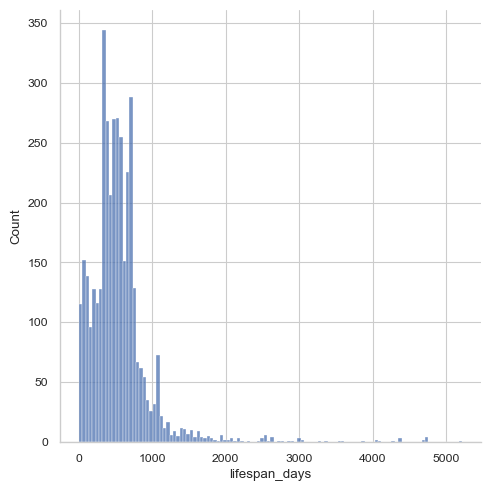

In [50]:
df['lifespan'] = df['dateLastAvailable'] - df['dateFirstAvailable']
df['lifespan_days'] = df['lifespan'].dt.days
sns.displot(df['lifespan_days'], kde=False)

Now the negatives are gone. 

We can calculate the median lifespan for imputation. But before that we do need to do a validation check as we have seen some mis matches in the `year` and `dateFirstAvailable` columns.

Also keeping in mind that there would be recent sets that are not yet retired. And we do not want to fill in lifespan for those sets.

In [51]:
df_backup = df.copy()
#df = df_backup

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7777 entries, 0 to 7776
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   name                       7777 non-null   object         
 1   year                       7777 non-null   int64          
 2   theme                      7777 non-null   object         
 3   themeGroup                 7773 non-null   object         
 4   subtheme                   6862 non-null   object         
 5   category                   7777 non-null   object         
 6   released                   7777 non-null   bool           
 7   pieces                     7620 non-null   float64        
 8   minifigs                   5220 non-null   float64        
 9   rating                     7777 non-null   float64        
 10  reviewCount                7777 non-null   int64          
 11  packagingType              7777 non-null   object       

In [53]:
subset = df[df['dateFirstAvailable'].notnull()]
subset['year_generated'] = subset['dateFirstAvailable'].dt.year

C:\Users\truon\AppData\Local\Temp\ipykernel_20768\3286758203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['year_generated'] = subset['dateFirstAvailable'].dt.year


In [54]:
subset.head()

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan,lifespan_days,year_generated
271,Straight Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,4.0,...,Retail,2007-10-24,2007-11-02,4515-1,22.476688,89.321095,6136.0,9 days,9.0,2007
272,Curved Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,3.7,...,Retail,2007-10-24,2007-11-02,4520-1,22.476688,61.886554,6136.0,9 days,9.0,2007
273,Manual Points with Track,1991,Trains,Modern day,9V,Normal,True,6.0,NaN,4.0,...,Retail,2007-10-24,2007-11-02,4531-1,48.431293,78.137416,6136.0,9 days,9.0,2007
274,Transformer and Speed Regulator,1991,Trains,Modern day,9V,Normal,True,3.0,NaN,3.7,...,Retail,2007-10-24,2007-11-02,4548-1,72.655591,602.373496,6136.0,9 days,9.0,2007
301,Large Building Plate,1992,Duplo,Pre-school,NaN,Normal,True,1.0,NaN,3.4,...,{Not specified},2007-10-29,2022-02-10,2304-1,27.876558,29.085075,922.0,5218 days,5218.0,2007


In [55]:
subset.shape

(4337, 22)

In [56]:
sum(subset['year'] != subset['year_generated'])

673

There are 673 rows with mis match years

In [57]:
mis_matches = subset[subset['year'] != subset['year_generated']]
mis_matches

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan,lifespan_days,year_generated
271,Straight Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,4.0,...,Retail,2007-10-24,2007-11-02,4515-1,22.476688,89.321095,6136.0,9 days,9.0,2007
272,Curved Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,3.7,...,Retail,2007-10-24,2007-11-02,4520-1,22.476688,61.886554,6136.0,9 days,9.0,2007
273,Manual Points with Track,1991,Trains,Modern day,9V,Normal,True,6.0,NaN,4.0,...,Retail,2007-10-24,2007-11-02,4531-1,48.431293,78.137416,6136.0,9 days,9.0,2007
274,Transformer and Speed Regulator,1991,Trains,Modern day,9V,Normal,True,3.0,NaN,3.7,...,Retail,2007-10-24,2007-11-02,4548-1,72.655591,602.373496,6136.0,9 days,9.0,2007
301,Large Building Plate,1992,Duplo,Pre-school,NaN,Normal,True,1.0,NaN,3.4,...,{Not specified},2007-10-29,2022-02-10,2304-1,27.876558,29.085075,922.0,5218 days,5218.0,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7663,Yellow Tusk Elephant,2023,Monkie Kid,Action/Adventure,Season 4,Normal,True,844.0,5.0,0.0,...,Retail - limited,2022-12-03,NaT,80043-1,130.352024,232.217305,NaN,NaT,NaN,2022
7664,Monkie Kid's Team Hideout,2023,Monkie Kid,Action/Adventure,Season 4,Normal,True,1582.0,6.0,4.6,...,Retail - limited,2022-12-03,NaT,80044-1,228.128264,264.203657,NaN,NaT,NaN,2022
7665,Monkey King Ultra Mech,2023,Monkie Kid,Action/Adventure,Season 4,Normal,True,1705.0,6.0,0.0,...,Retail - limited,2022-11-08,2023-11-24,80045-1,260.720344,350.715441,270.0,381 days,381.0,2022
7670,Lunar New Year Display,2023,Seasonal,Miscellaneous,Chinese Traditional Festival,Normal,True,872.0,NaN,0.0,...,LEGO exclusive,2022-11-08,2023-12-25,80110-1,146.648064,193.291722,239.0,412 days,412.0,2022


In [58]:
for i in mis_matches.index:
    day = mis_matches.loc[i, 'dateFirstAvailable'].day
    month = mis_matches.loc[i, 'dateFirstAvailable'].month
    full = str(mis_matches.loc[i, 'year']) + '-' + str(month) + '-' + str(day)
    df.loc[i, 'dateFirstAvailable'] = pd.to_datetime(full)
df

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,packagingType,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan,lifespan_days
0,Taxi,1971,LEGOLAND,Vintage,Vehicle,Normal,True,19.0,NaN,0.0,...,Box,Retail,NaT,NaT,605-2,NaN,105.829737,NaN,NaT,NaN
1,Articulated Lorry,1971,LEGOLAND,Vintage,Vehicle,Normal,True,58.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,683-1,NaN,540.334429,NaN,NaT,NaN
2,Low-Loader Truck with Forklift,1972,LEGOLAND,Vintage,Vehicle,Normal,True,53.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,684-1,NaN,419.292288,NaN,NaT,NaN
3,Basic Set,1973,Universal Building Set,Basic,NaN,Normal,True,184.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,3-4,NaN,342.019044,NaN,NaT,NaN
4,Basic Set,1973,Universal Building Set,Basic,NaN,Normal,True,415.0,NaN,0.0,...,{Not specified},{Not specified},NaT,NaT,7-3,NaN,209.542879,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7772,Disney Mini Castle,2023,Promotional,Miscellaneous,LEGO brand stores,Extended,True,60.0,NaN,0.0,...,None (loose parts),Promotional,NaT,NaT,6470860-1,NaN,44.695533,NaN,NaT,NaN
7773,Buildable Cassette Player,2023,Promotional,Miscellaneous,Insiders Reward,Extended,True,145.0,NaN,0.0,...,Box,LEGO exclusive,NaT,NaT,6471612-1,NaN,50.776137,NaN,NaT,NaN
7774,Buildable Grey Castle,2023,Promotional,Miscellaneous,Insiders Reward,Extended,True,112.0,NaN,0.0,...,Box,LEGO exclusive,NaT,NaT,6487474-1,NaN,72.725767,NaN,NaT,NaN
7775,Taxi,2023,Marvel Super Heroes,Licensed,Promotional,Extended,True,150.0,NaN,0.0,...,Box,LEGO exclusive,NaT,NaT,6487481-1,NaN,124.771254,NaN,NaT,NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7777 entries, 0 to 7776
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   name                       7777 non-null   object         
 1   year                       7777 non-null   int64          
 2   theme                      7777 non-null   object         
 3   themeGroup                 7773 non-null   object         
 4   subtheme                   6862 non-null   object         
 5   category                   7777 non-null   object         
 6   released                   7777 non-null   bool           
 7   pieces                     7620 non-null   float64        
 8   minifigs                   5220 non-null   float64        
 9   rating                     7777 non-null   float64        
 10  reviewCount                7777 non-null   int64          
 11  packagingType              7777 non-null   object       

In [60]:
df['lifespan'] = df['dateLastAvailable'] - df['dateFirstAvailable']
df['lifespan_days'] = df['lifespan'].dt.days

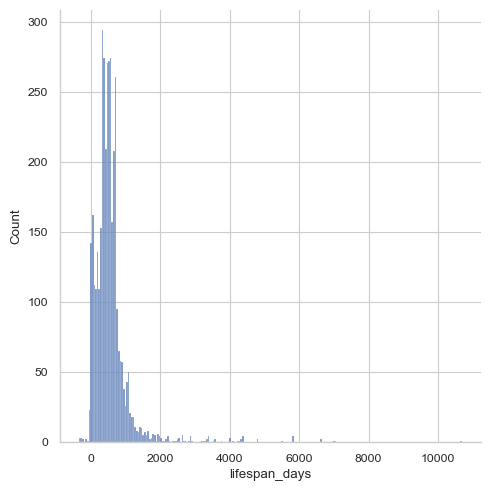

In [61]:
sns.displot(df['lifespan_days'], kde=False)

In [62]:
df[df['lifespan_days'] > 5000]

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,...,packagingType,availability,dateFirstAvailable,dateLastAvailable,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan,lifespan_days
271,Straight Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,4.0,...,Box,Retail,1991-10-24,2007-11-02,4515-1,22.476688,89.321095,6136.0,5853 days,5853.0
272,Curved Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,3.7,...,Box,Retail,1991-10-24,2007-11-02,4520-1,22.476688,61.886554,6136.0,5853 days,5853.0
273,Manual Points with Track,1991,Trains,Modern day,9V,Normal,True,6.0,NaN,4.0,...,Box,Retail,1991-10-24,2007-11-02,4531-1,48.431293,78.137416,6136.0,5853 days,5853.0
274,Transformer and Speed Regulator,1991,Trains,Modern day,9V,Normal,True,3.0,NaN,3.7,...,Box,Retail,1991-10-24,2007-11-02,4548-1,72.655591,602.373496,6136.0,5853 days,5853.0
301,Large Building Plate,1992,Duplo,Pre-school,NaN,Normal,True,1.0,NaN,3.4,...,{Not specified},{Not specified},1992-10-29,2022-02-10,2304-1,27.876558,29.085075,922.0,10696 days,10696.0
318,Straight Track (Straight Rails),1993,Duplo,Pre-school,Trains,Normal,True,6.0,NaN,0.0,...,{Not specified},{Not specified},1993-10-24,2013-02-15,2734-1,9.225287,18.288242,4204.0,7054 days,7054.0
319,Curved Track (Curved Rails),1993,Duplo,Pre-school,Trains,Normal,True,6.0,NaN,0.0,...,{Not specified},{Not specified},1993-10-29,2012-12-27,2735-1,9.225287,19.444811,4254.0,6999 days,6999.0
378,"Building Plate, Green",1996,Basic,Basic,Supplementaries,Normal,True,1.0,NaN,4.1,...,Other,Retail,1996-10-24,2014-12-02,626-1,7.259407,17.930000,3549.0,6613 days,6613.0
380,X-Large Baseplate Grey,1996,Basic,Basic,Supplementaries,Normal,True,1.0,NaN,3.9,...,Shrink-wrapped,Retail,1996-10-24,2014-12-23,628-1,21.807317,37.958945,3528.0,6634 days,6634.0
381,"Brick Separator, Green",1996,Basic,Basic,Supplementaries,Normal,True,1.0,NaN,4.4,...,Polybag,Retail,1996-10-24,2011-12-03,630-1,3.622430,7.408082,4644.0,5518 days,5518.0


In [63]:
missing_values(df)

themeGroup: 0.05%
subtheme: 11.77%
pieces: 2.02%
minifigs: 32.88%
dateFirstAvailable: 44.23%
dateLastAvailable: 50.69%
NZ_retailPrice: 44.27%
days_since_last_available: 50.69%
lifespan: 50.69%
lifespan_days: 50.69%


We will keep only rows which we have data on `dateLastAvailable` to ensure we only using retired sets.

In [64]:
df = df[-df['dateLastAvailable'].isna()]

missing_values(df)

subtheme: 13.56%
pieces: 0.81%
minifigs: 28.89%
NZ_retailPrice: 0.08%


In [65]:
df.shape

(3835, 21)

Now we can drop the `dateFirstAvailable`,  `dateLastAvailable` and `lifespan` as we now have `lifespan_days` and `days_since_last_avaialbe` as our feature.

In [66]:
df.drop(['dateFirstAvailable', 'dateLastAvailable', 'lifespan'], axis=1, inplace=True)

C:\Users\truon\AppData\Local\Temp\ipykernel_20768\2918853055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['dateFirstAvailable', 'dateLastAvailable', 'lifespan'], axis=1, inplace=True)


In [67]:
df['lifespan_days'] = df['lifespan_days'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3835 entries, 271 to 7670
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       3835 non-null   object 
 1   year                       3835 non-null   int64  
 2   theme                      3835 non-null   object 
 3   themeGroup                 3835 non-null   object 
 4   subtheme                   3315 non-null   object 
 5   category                   3835 non-null   object 
 6   released                   3835 non-null   bool   
 7   pieces                     3804 non-null   float64
 8   minifigs                   2727 non-null   float64
 9   rating                     3835 non-null   float64
 10  reviewCount                3835 non-null   int64  
 11  packagingType              3835 non-null   object 
 12  availability               3835 non-null   object 
 13  set_number                 3835 non-null   obj

C:\Users\truon\AppData\Local\Temp\ipykernel_20768\3988626674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lifespan_days'] = df['lifespan_days'].astype(int)


In [83]:
missing_values(df)

subtheme: 13.56%
pieces: 0.81%
minifigs: 28.89%
NZ_retailPrice: 0.08%


**Change of Strategy**:
- `subtheme`: fill with *"Unknown"*
- `pieces`: get more data from Brickeconomy and fill the missing values.
- `NZ_retailPrice`: get more data from Brickeconomy and fill the missing values.

#### Pieces and US_retailPrice

In [84]:
df.isna().sum()

name                            0
year                            0
theme                           0
themeGroup                      0
subtheme                      520
category                        0
released                        0
pieces                         31
minifigs                     1108
rating                          0
reviewCount                     0
packagingType                   0
availability                    0
set_number                      0
NZ_retailPrice                  3
mean_nzd_new                    0
days_since_last_available       0
lifespan_days                   0
dtype: int64

In [68]:
import requests

# Function to get set information from the Brickeconomy website
def get_economy_set(set_num):
    url = 'https://www.brickeconomy.com/api/v1/set/{}?currency=NZD'.format(set_num)
    headers = {
        'accept': 'application/json',
        'x-apikey': 'd76d4466-58b3-408b-961b-d2abaf081a2a',
        'User-Agent': "Lam"
    }
    response = requests.get(url, headers=headers)
    #columns_to_keep = ['set_number','name','pieces_count', 'minifigs_count', 'currency', 'retail_price_us']
    if response.status_code == 200:
        print('Connection Successful')
        df = pd.DataFrame(response.json())
        df = df.T
        return df
    if response.status_code == 400:
        print('Set not found', set_num)
    
    if response.status_code == 429:
        print('Rate limit exceeded')

In [7]:
result = get_economy_set('30473-1')
result

Connection Successful


,availability,currency,current_value_new,current_value_used,current_value_used_high,current_value_used_low,forecast_value_new_2_years,forecast_value_new_5_years,minifigs,minifigs_count,...,price_events_new,price_events_used,retired,rolling_growth_12months,rolling_growth_lastyear,set_number,subtheme,theme,upc,year
data,promotional,USD,6.47,4.13,4.96,4.05,8.29,10.36,[rac061],1,...,"[{'date': '2024-09-27', 'value': 6.47}, {'date...","[{'date': '2024-09-29', 'value': 4.13}, {'date...",True,3.29,-3.4,30473-1,City,Juniors,673419251075,2016


In [8]:
result.T

,data
availability,promotional
currency,USD
current_value_new,6.47
current_value_used,4.13
current_value_used_high,4.96
current_value_used_low,4.05
forecast_value_new_2_years,8.29
forecast_value_new_5_years,10.36
minifigs,[rac061]
minifigs_count,1


In [69]:
missing_retails = df[df['NZ_retailPrice'].isna()]['set_number'].tolist()

for set_num in missing_retails:
    set_info = get_economy_set(set_num)
    if set_info is not None and 'retail_price_us' in set_info.columns:
        retail_price = set_info['retail_price_us'].values[0]
        nzd_price = retail_price * usd['2024']
        df.loc[df['set_number'] == set_num, 'NZ_retailPrice'] = nzd_price
    else: # No retail price found / free / promotional
        df.loc[df['set_number'] == set_num, 'NZ_retailPrice'] = 0

Connection Successful
Connection Successful
Connection Successful


In [70]:
missing_pieces = df[df['pieces'].isna()]['set_number'].tolist()

for set_num in missing_pieces:
    set_info = get_economy_set(set_num)
    if set_info is not None and 'pieces_count' in set_info.columns:
        pieces = set_info['pieces_count'].values[0]
        df.loc[df['set_number'] == set_num, 'pieces'] = pieces

Set not found 851499-1
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful
Connection Successful


In [71]:
# Fill the rest with 0
df['pieces'] = df['pieces'].fillna(0)

missing_values(df)

subtheme: 13.56%
minifigs: 28.89%


C:\Users\truon\AppData\Local\Temp\ipykernel_20768\1808074227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pieces'] = df['pieces'].fillna(0)


In [72]:
df[df['theme'] == 'Collectable Minifigures']

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan_days
1575,Tribal Hunter,2010,Collectable Minifigures,Miscellaneous,Series 1,Normal,True,9.0,1.0,3.7,12,Foil pack,Retail,8683-1,2.761433,84.265025,5178.0,13
1576,Cheerleader,2010,Collectable Minifigures,Miscellaneous,Series 1,Normal,True,7.0,1.0,3.8,8,Foil pack,Retail,8683-2,2.761433,62.817258,5178.0,13
1577,Caveman,2010,Collectable Minifigures,Miscellaneous,Series 1,Normal,True,6.0,1.0,3.8,11,Foil pack,Retail,8683-3,2.761433,45.665708,5178.0,13
1578,Circus Clown,2010,Collectable Minifigures,Miscellaneous,Series 1,Normal,True,6.0,1.0,3.9,14,Foil pack,Retail,8683-4,2.761433,77.370371,5178.0,13
1579,Zombie,2010,Collectable Minifigures,Miscellaneous,Series 1,Normal,True,6.0,1.0,3.9,10,Foil pack,Retail,8683-5,2.761433,96.260198,5178.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7451,LEGO Minifigures - Disney 100 Series {Box of 6...,2023,Collectable Minifigures,Miscellaneous,Disney 100 Series,Random,True,0.0,NaN,0.0,0,Box,Retail - limited,66734-1,48.790344,71.474069,463.0,42
7470,Newspaper Kid,2023,Collectable Minifigures,Miscellaneous,Series 24,Normal,True,8.0,1.0,4.2,1,Foil pack,Retail,71037-12,8.131724,8.404027,419.0,-149
7493,LEGO Minifigures - Disney 100 Series - Sealed Box,2023,Collectable Minifigures,Miscellaneous,Disney 100 Series,Collection,True,0.0,NaN,0.0,0,Box,{Not specified},71038-20,8.131724,466.063336,364.0,173
7503,Echo,2023,Collectable Minifigures,Miscellaneous,Marvel Studios Series 2,Normal,True,8.0,1.0,3.7,0,Box,Retail,71039-9,8.131724,8.385356,363.0,1


Also, the prices for "Collectable Minifigures" seems to be very inflated. We will remove these rows. It seems like brickset would only refer retail price for a "single minifigure" rather than a whole set (a collection of minifigures).

Without knowledge of the accuracy of the information for retail prices for these sets, we will remove them from the dataset.

In [73]:
df = df[df['theme'] != 'Collectable Minifigures']

In [74]:
df.isna().sum()

name                            0
year                            0
theme                           0
themeGroup                      0
subtheme                      520
category                        0
released                        0
pieces                          0
minifigs                     1083
rating                          0
reviewCount                     0
packagingType                   0
availability                    0
set_number                      0
NZ_retailPrice                  0
mean_nzd_new                    0
days_since_last_available       0
lifespan_days                   0
dtype: int64

#### Subtheme

In [75]:
df['subtheme'].fillna('Unknown', inplace=True)

In [76]:
missing_values(df)

minifigs: 29.27%


#### minifigs

Not all sets contain minifigs. We will fill the missing values with 0.

In [77]:
df['minifigs'].isna().sum()

1083

<AxesSubplot: xlabel='minifigs', ylabel='Count'>

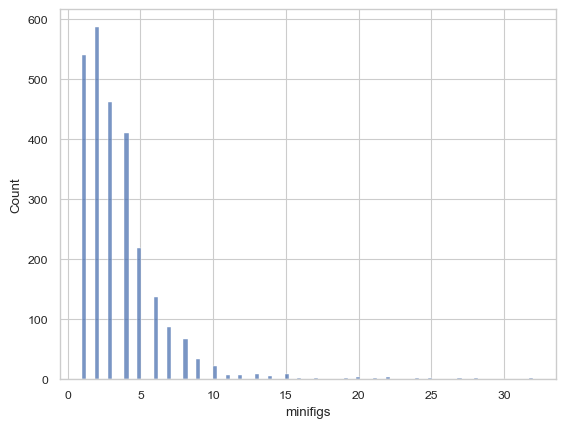

In [78]:
sns.histplot(df['minifigs'], kde=False)

In [79]:
df[df['minifigs'].isna()]

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan_days
271,Straight Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,4.0,3,Box,Retail,4515-1,22.476688,89.321095,6136.0,5853
272,Curved Rails,1991,Trains,Modern day,9V,Normal,True,8.0,NaN,3.7,1,Box,Retail,4520-1,22.476688,61.886554,6136.0,5853
273,Manual Points with Track,1991,Trains,Modern day,9V,Normal,True,6.0,NaN,4.0,2,Box,Retail,4531-1,48.431293,78.137416,6136.0,5853
274,Transformer and Speed Regulator,1991,Trains,Modern day,9V,Normal,True,3.0,NaN,3.7,2,Box,Retail,4548-1,72.655591,602.373496,6136.0,5853
301,Large Building Plate,1992,Duplo,Pre-school,Unknown,Normal,True,1.0,NaN,3.4,2,{Not specified},{Not specified},2304-1,27.876558,29.085075,922.0,10696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7519,Character Pack Series 6 - Sealed Box,2023,Super Mario,Licensed,Character Pack - Series 6,Collection,True,0.0,NaN,0.0,0,Box,{Not specified},71413-10,9.761328,180.695784,364.0,184
7531,Piranha Plant,2023,Super Mario,Licensed,Miscellaneous,Normal,True,540.0,NaN,0.0,0,Box,Retail,71426-1,97.759944,119.136987,234.0,99
7573,Princess Leia (Boushh) Helmet,2023,Star Wars,Licensed,Helmet Collection,Normal,True,670.0,NaN,4.2,1,Box,Retail,75351-1,114.055984,164.636807,243.0,328
7608,Venomized Groot,2023,Marvel Super Heroes,Licensed,Miscellaneous,Normal,True,630.0,NaN,0.0,0,Box,Retail,76249-1,81.463904,79.438893,224.0,227


In [80]:
df['minifigs'].fillna(0, inplace=True)

In [81]:
missing_values(df)

#### days_since_last_available
Lastly We will also convert it to `years_since_last_available` for better interpretation.

In [82]:
df['years_since_last_available'] = df['days_since_last_available'] / 365

In [83]:
df.shape

(3700, 19)

No more missing values in the dataset. And we are left with 3700 observations.


----

Now we have a complete dataset for building a price prediction model.

Next steps:
- **Feature selection**: Keep only the features given in real life when a person want to invest in a LEGO set.
- **Feature engineering**: Create new features that might be useful for our model.
- **Model building**: Try a range of models and evaluate them with baseline models and with each other.
- **Model fine-tuning**: Tune the best model to get increase performance.
---

## Target Variable
There are two proposed target variables:
1. **Adjusted Absolute Return** 

- This scales the return based on the number of days since the set was retired. 
- The result represents the average daily change in value of the item since it was retired.
- Higher means set is generating more profit per day since retired.
>$
\text{Adjusted Absolute Return} = \frac{\text{Market Value} - \text{Retail Price}}{\text{Days Since Retired}}
$

----
2. **Annualized ROI**

- The formula calculates an adjusted annual return rate, showing how much return (as a percentage) the LEGO set has earned on average per year since retirement.
- Use case of our model is when an investor wants to invest in a LEGO set, they can use the model to predict the annualized ROI having `years_since_last_available` as a parameter (eg. 1 year, 2 years, 3 years, etc.) --> this would give him an idea of how much return he can expect to gain for a certain sets.

>$
 \text{Annualized ROI} = \frac{\left( \frac{\text{Market value} - \text{Retail Price}}{\text{Retail Price}} \right)}{\text{Years Since Retirement}} \times 100
$

----
After considerations, we will use the **Annualized ROI** as our target variable.

In [84]:
df[df['NZ_retailPrice'] == 0]

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan_days,years_since_last_available
3306,Racer,2016,Juniors,Junior,City,Normal,True,30.0,1.0,3.2,0,Polybag,{Not specified},30473-1,0.0,10.475446,2416.0,734,6.619178


In [85]:
# To avoid division by zero we will remove this row too.
df.drop(df[df['NZ_retailPrice'] == 0].index, inplace=True)

In [86]:
# Calculated our target variable
df['annualized_roi'] = (((df['mean_nzd_new'] - df['NZ_retailPrice']) / df['NZ_retailPrice']) / df['years_since_last_available'])* 100

In [87]:
df['annualized_roi'].describe()

count     3699.000000
mean        43.438343
std        375.867324
min        -32.614762
25%         14.418227
50%         25.552613
75%         43.565261
max      22487.394476
Name: annualized_roi, dtype: float64

In [88]:
df[df['annualized_roi'] == df['annualized_roi'].max()]

,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,set_number,NZ_retailPrice,mean_nzd_new,days_since_last_available,lifespan_days,years_since_last_available,annualized_roi
3726,Rebel A-wing Pilot,2016,Star Wars,Licensed,Rebels,Extended,True,5.0,1.0,3.9,3,Polybag,Promotional,5004408-1,0.015894,19.688921,2009.0,1106,5.50411,22487.394476


## Exploratory Data Analysis
### Exploring the relationship between the features and the target variable

In [89]:
#df.to_csv('bricksetowl.csv', index=False)

In [90]:
#df = merged.copy()
df = pd.read_csv('bricksetowl.csv')

In [91]:
df.columns

Index(['name', 'year', 'theme', 'themeGroup', 'subtheme', 'category',
       'released', 'pieces', 'minifigs', 'rating', 'reviewCount',
       'packagingType', 'availability', 'set_number', 'NZ_retailPrice',
       'mean_nzd_new', 'days_since_last_available', 'lifespan_days',
       'years_since_last_available', 'annualized_roi'],
      dtype='object')

In [92]:
# Rename for better understanding
df.rename(columns={'mean_nzd_new': 'market_value'}, inplace=True)

In [93]:
# Rearranging columns
df = df[['set_number', 'name', 'year', 'theme', 'themeGroup', 'subtheme', 'category',
       'released', 'pieces', 'minifigs', 'rating', 'reviewCount',
       'packagingType', 'availability','lifespan_days','years_since_last_available', 'NZ_retailPrice', 'market_value',
       'annualized_roi']]

In [94]:
df[df['annualized_roi'] > df['annualized_roi'].quantile(0.95)].sort_values(by='annualized_roi', ascending=False).head(10)

,set_number,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,lifespan_days,years_since_last_available,NZ_retailPrice,market_value,annualized_roi
1657,5004408-1,Rebel A-wing Pilot,2016,Star Wars,Licensed,Rebels,Extended,True,5.0,1.0,3.9,3,Polybag,Promotional,1106,5.504110,0.015894,19.688921,22487.394476
3153,43108-14,Bandmates Series 2 - Sealed Box,2021,Vidiyo,Licensed,Bandmates - Series 2,Collection,True,0.0,0.0,0.0,0,Box,{Not specified},0,2.797260,7.061544,542.123496,2708.766358
3673,71413-10,Character Pack Series 6 - Sealed Box,2023,Super Mario,Licensed,Character Pack - Series 6,Collection,True,0.0,0.0,0.0,0,Box,{Not specified},184,0.997260,9.761328,180.695784,1755.950188
3672,71413-9,Character Pack Series 6 - Complete,2023,Super Mario,Licensed,Character Pack - Series 6,Collection,True,0.0,10.0,0.0,0,{Not specified},Retail,1,0.994521,9.644601,137.522005,1333.201455
3146,43101-14,Bandmates Series 1 - Sealed Box,2021,Vidiyo,Licensed,Bandmates - Series 1,Collection,True,0.0,0.0,0.0,0,Box,{Not specified},355,2.501370,7.061544,214.020807,1171.675400
3224,71394-11,Character Pack Series 3 - Complete,2021,Super Mario,Licensed,Character Pack - Series 3,Collection,True,0.0,10.0,0.0,0,{Not specified},Retail,139,2.671233,7.061544,143.660153,724.160580
3419,40568-1,Paris Postcard,2022,Creator,Model making,Postcard,Normal,True,213.0,0.0,3.7,1,Box,LEGO exclusive,508,0.679452,23.660696,113.518991,558.948572
3633,40625-1,Llama,2023,BrickHeadz,Licensed,Minecraft,Normal,True,100.0,0.0,4.2,0,Box,Retail,250,0.753425,16.279744,67.092003,414.267732
2033,40197-1,Wedding Favour Set 2018,2018,Miscellaneous,Miscellaneous,Unknown,Normal,True,132.0,2.0,3.9,2,Box,LEGO exclusive,1492,2.523288,14.453102,153.464306,381.172847
2857,71370-1,Fire Mario Power-Up Pack,2020,Super Mario,Licensed,Power-Up Pack,Normal,True,11.0,0.0,3.4,2,Box,Retail,552,2.539726,15.382742,158.244499,365.675082


In [95]:
df['availability'].value_counts()

Retail              2772
LEGO exclusive       465
Retail - limited     233
{Not specified}      215
Promotional            7
Not sold               6
Educational            1
Name: availability, dtype: int64

In [96]:
df['annualized_roi_log'] = np.log1p(df['annualized_roi'])

d:\computer programming\anaconda\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   set_number                  3699 non-null   object 
 1   name                        3699 non-null   object 
 2   year                        3699 non-null   int64  
 3   theme                       3699 non-null   object 
 4   themeGroup                  3699 non-null   object 
 5   subtheme                    3699 non-null   object 
 6   category                    3699 non-null   object 
 7   released                    3699 non-null   bool   
 8   pieces                      3699 non-null   float64
 9   minifigs                    3699 non-null   float64
 10  rating                      3699 non-null   float64
 11  reviewCount                 3699 non-null   int64  
 12  packagingType               3699 non-null   object 
 13  availability                3699 

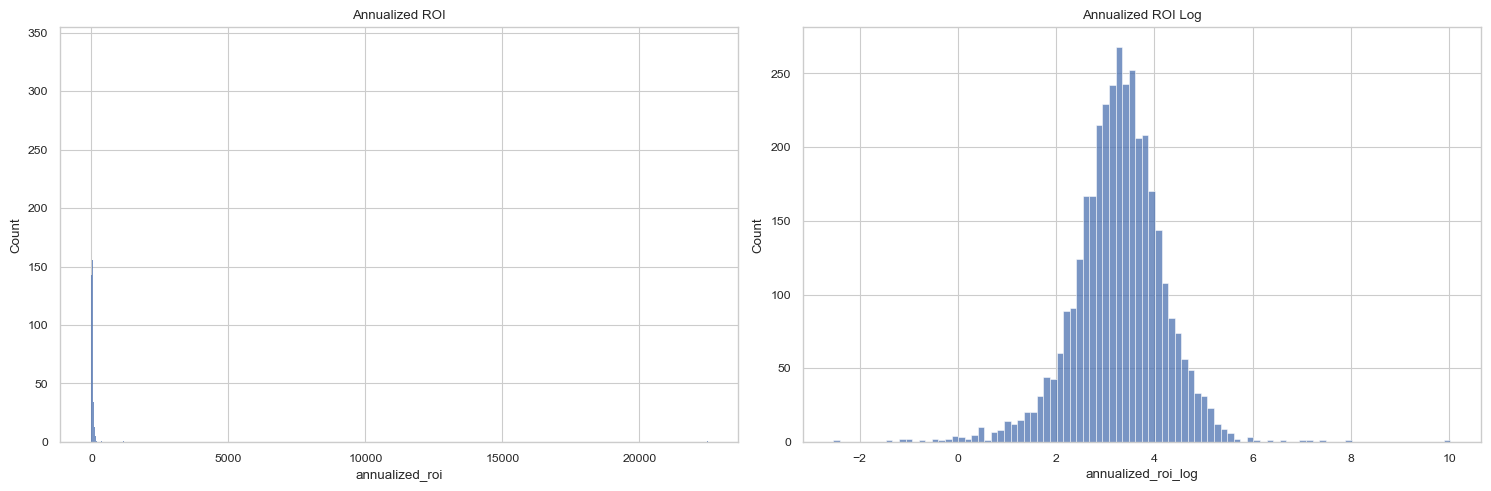

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first subplot
sns.histplot(df['annualized_roi'], kde=False, ax=ax[0])
ax[0].set_title('Annualized ROI')

# Plot the second subplot
sns.histplot(df['annualized_roi_log'], kde=False, ax=ax[1])
ax[1].set_title('Annualized ROI Log')

# Adjust layout
plt.tight_layout()
plt.show()

The distribution of the target variable `adjusted_absolute_return` is extremely right-skewed with presents of extreme outliers.

In [58]:
df.query('annualized_roi == annualized_roi.max()')

,set_number,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,lifespan_days,years_since_last_available,NZ_retailPrice,market_value,annualized_roi,annualized_roi_log
3152,43108-14,Bandmates Series 2 - Sealed Box,2021,Vidiyo,Licensed,Bandmates - Series 2,Collection,True,0.0,0.0,0.0,0,Box,{Not specified},0,2.79726,7.061544,542.123496,2708.766358,7.904618


This set is showing a retail price of $0.01 NZD which is clearly a mistake. We will remove this row.

In [59]:
df.drop(1657, inplace=True)

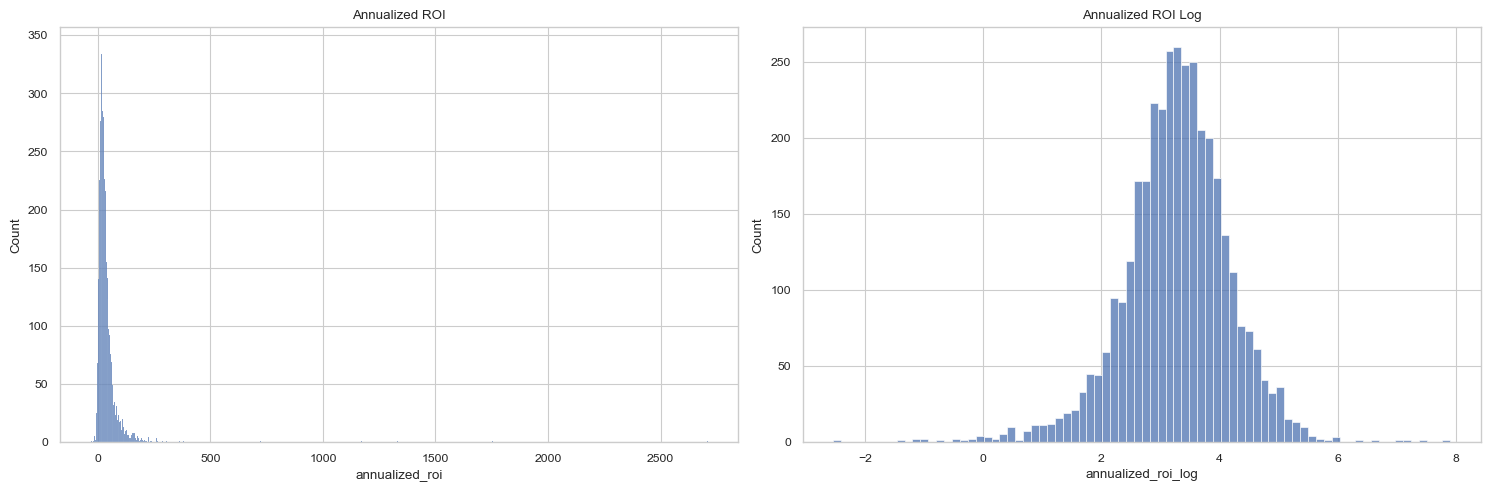

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the first subplot
sns.histplot(df['annualized_roi'], kde=False, ax=ax[0])
ax[0].set_title('Annualized ROI')

# Plot the second subplot
sns.histplot(df['annualized_roi_log'], kde=False, ax=ax[1])
ax[1].set_title('Annualized ROI Log')

# Adjust layout
plt.tight_layout()
plt.show()

In [61]:
df.to_csv('bricksetowl.csv', index=False)

In [62]:
df = pd.read_csv('bricksetowl.csv')
df

,set_number,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,rating,reviewCount,packagingType,availability,lifespan_days,years_since_last_available,NZ_retailPrice,market_value,annualized_roi,annualized_roi_log
0,4515-1,Straight Rails,1991,Trains,Modern day,9V,Normal,True,8.0,0.0,4.0,3,Box,Retail,5853,16.810959,22.476688,89.321095,17.690507,2.928016
1,4520-1,Curved Rails,1991,Trains,Modern day,9V,Normal,True,8.0,0.0,3.7,1,Box,Retail,5853,16.810959,22.476688,61.886554,10.429900,2.436233
2,4531-1,Manual Points with Track,1991,Trains,Modern day,9V,Normal,True,6.0,0.0,4.0,2,Box,Retail,5853,16.810959,48.431293,78.137416,3.648610,1.536568
3,4548-1,Transformer and Speed Regulator,1991,Trains,Modern day,9V,Normal,True,3.0,0.0,3.7,2,Box,Retail,5853,16.810959,72.655591,602.373496,43.369371,3.792549
4,2304-1,Large Building Plate,1992,Duplo,Pre-school,Unknown,Normal,True,1.0,0.0,3.4,2,{Not specified},{Not specified},10696,2.526027,27.876558,29.085075,1.716230,0.999245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,76914-1,Ferrari 812 Competizione,2023,Speed Champions,Licensed,Ferrari,Normal,True,261.0,1.0,4.4,0,Box,Retail,369,0.619178,40.723804,47.188586,25.638344,3.282352
3693,76916-1,Porsche 963,2023,Speed Champions,Licensed,Porsche,Normal,True,280.0,1.0,4.2,0,Box,Retail,372,0.610959,40.723804,50.030905,37.407105,3.648242
3694,76918-1,McLaren Solus GT & McLaren F1 LM,2023,Speed Champions,Licensed,McLaren,Normal,True,581.0,2.0,4.4,3,Box,Retail,359,0.646575,57.019844,84.252314,73.865539,4.315694
3695,80045-1,Monkey King Ultra Mech,2023,Monkie Kid,Action/Adventure,Season 4,Normal,True,1705.0,6.0,0.0,0,Box,Retail - limited,16,0.739726,260.720344,350.715441,46.663040,3.864156


#### Numerical features

In [99]:
df.dtypes

set_number                     object
name                           object
year                            int64
theme                          object
themeGroup                     object
subtheme                       object
category                       object
released                         bool
pieces                        float64
minifigs                      float64
rating                        float64
reviewCount                     int64
packagingType                  object
availability                   object
lifespan_days                   int64
years_since_last_available    float64
NZ_retailPrice                float64
market_value                  float64
annualized_roi                float64
annualized_roi_log            float64
dtype: object

In [105]:
numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [106]:
#numerical_cols = numerical_cols[:-1]

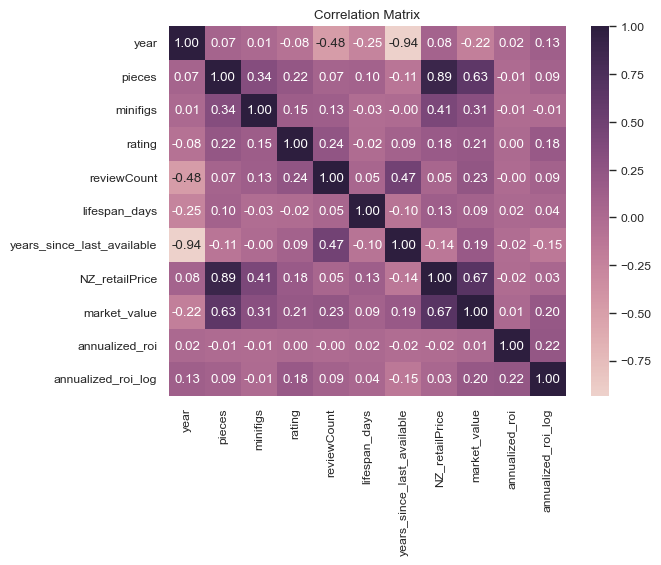

In [108]:
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='.2f')
plt.title('Correlation Matrix');

**Observations** - There are relatively little to no correlation between the numerical features and the target variable.

In [141]:
numerical_cols[:-2]

['year',
 'pieces',
 'minifigs',
 'rating',
 'reviewCount',
 'lifespan_days',
 'years_since_last_available',
 'NZ_retailPrice',
 'market_value']

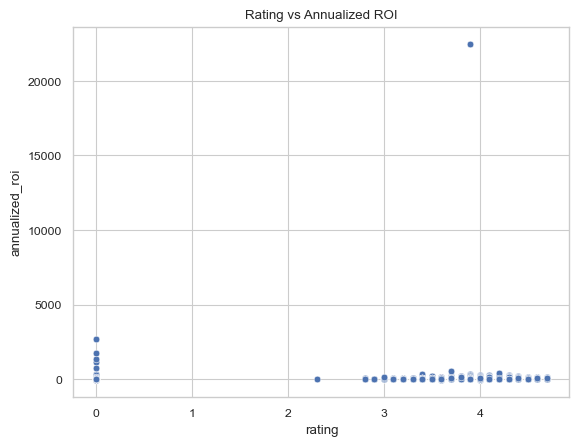

In [110]:
sns.scatterplot(x='rating', y='annualized_roi', data=df)
plt.title('Rating vs Annualized ROI');

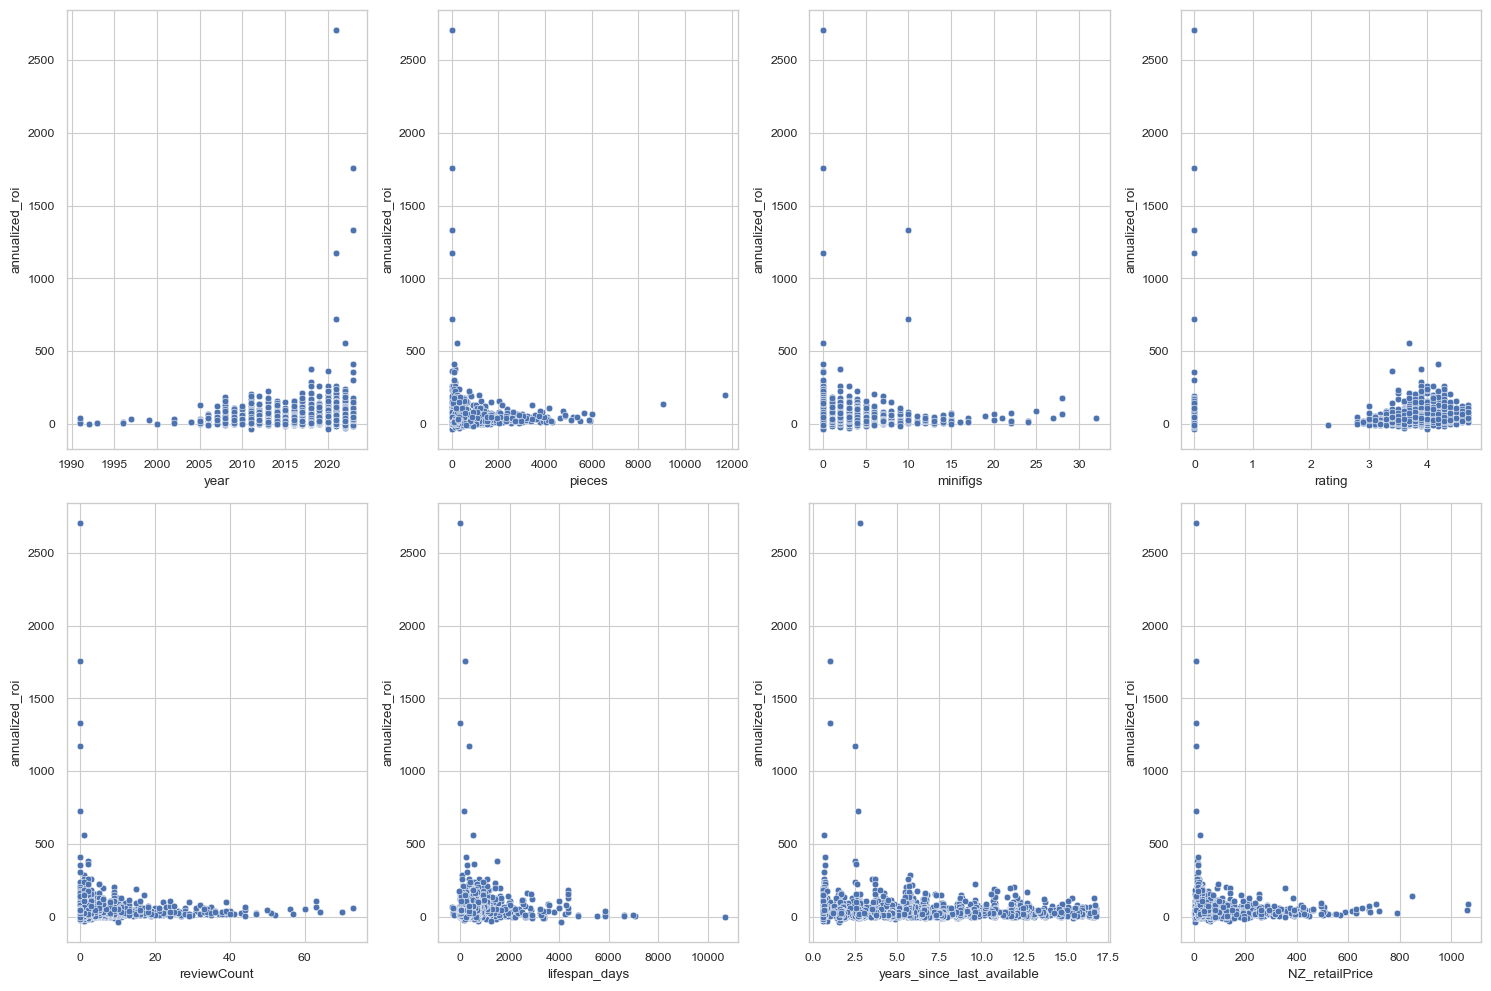

In [142]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
col_index = 0
for i in range(2):
    for j in range(4):
        sns.scatterplot(data=df, x=numerical_cols[:-2][col_index], y='annualized_roi', ax=ax[i, j])
        col_index += 1
plt.tight_layout()
plt.show()

**Observations:**
- The strength of the correlations are affected by the presense of zero values in the features.
- There seem to be more sets with higher annualized ROI for later years.
- Some extreme high annualized ROI sets with only 0 or 1 pieces. (One example for this is the `COMCON018 Batman` which is extremely rare and only gave away for those who attended the comic con event in NY and hold a special benchmark before the launch of **lego super heroes** in January 2012).
- Sets containing between 0 to 10 mini figures have higher values.
- For ratings, 0 and between 4 and 5 ratings score having higher annualized ROI. However, we may need to investigate the 0 rating score sets as they might be 'No rating' instead of 0 rating score.
- Sets with low lifespan have higher values (indicating rareness of the sets).

**Fixing Rating:**

Looking through the Brickset website. We can further comfirm that 0 actually means 'Not yet rated'. The rating score on Brickset is only between 1 to 5.

To deal with this we will creating a binary column `rated` to indicate if the set has been rated or not. So our model will have more information and not get confused by the meaning of 0.

In [63]:
df['rated'] = df['rating'].apply(lambda x: 1 if x > 0 else 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3697 entries, 0 to 3696
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   set_number                  3697 non-null   object 
 1   name                        3697 non-null   object 
 2   year                        3697 non-null   int64  
 3   theme                       3697 non-null   object 
 4   themeGroup                  3697 non-null   object 
 5   subtheme                    3697 non-null   object 
 6   category                    3697 non-null   object 
 7   released                    3697 non-null   bool   
 8   pieces                      3697 non-null   float64
 9   minifigs                    3697 non-null   float64
 10  rating                      3697 non-null   float64
 11  reviewCount                 3697 non-null   int64  
 12  packagingType               3697 non-null   object 
 13  availability                3697 

In [144]:
df['rated'].value_counts()

1    3222
0     476
Name: rated, dtype: int64

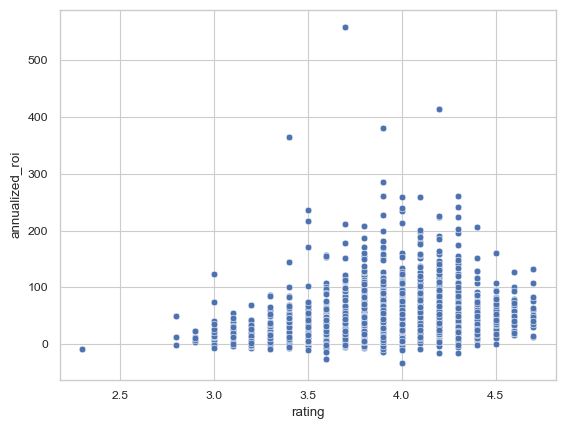

In [145]:
subset = df[(df['rated'] == 1) & (df['rating'] > 0)]
sns.scatterplot(data=subset, x='rating', y='annualized_roi');

We can see that high annualized ROI sets are rated between 3.5 to 4.3.

#### Categorical features

In [170]:
categorical_cols

['set_number',
 'name',
 'theme',
 'themeGroup',
 'subtheme',
 'category',
 'packagingType',
 'availability']

**Availability**

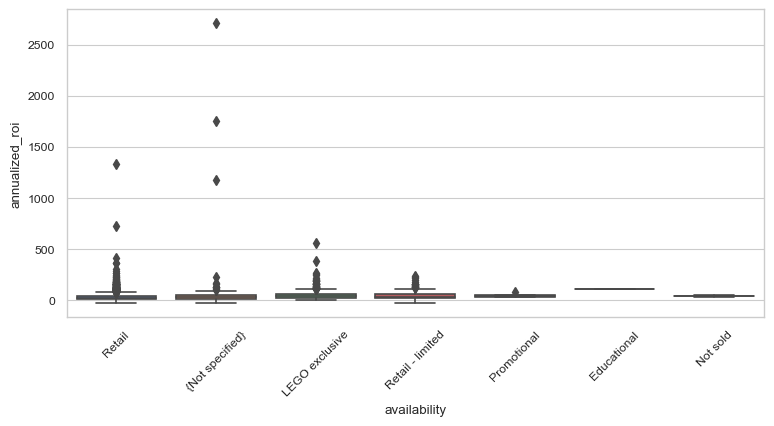

In [147]:
plt.figure(figsize=(9, 4))
sns.boxplot(data=df, x='availability', y='annualized_roi')
plt.xticks(rotation=45);

**Lego exclusive**, **promotional** and **Retail** availability sets have a more extreme higher market value compared to other availability types.

Let's exclude the high values sets to have a better view of the others.

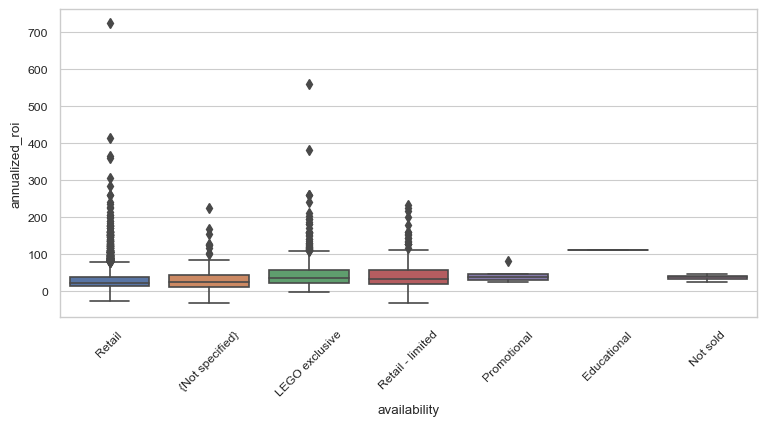

In [148]:
plt.figure(figsize=(9, 4))
sns.boxplot(data=df[df['annualized_roi']<1000], x='availability', y='annualized_roi')
plt.xticks(rotation=45);

There are not much difference in distribution of `annualized_roi` by `availability`. Some extreme high values belongs to **Retail** and **{Not specified}**

In [149]:
df['availability'].value_counts()

Retail              2772
LEGO exclusive       465
Retail - limited     233
{Not specified}      215
Promotional            6
Not sold               6
Educational            1
Name: availability, dtype: int64

**Theme group, theme and subtheme**

In [150]:
df['themeGroup'].value_counts()

Licensed            1412
Modern day           677
Action/Adventure     370
Miscellaneous        330
Model making         287
Technical            198
Pre-school           130
Art and crafts        69
Constraction          50
Basic                 49
Historical            49
Racing                36
Junior                34
Educational            6
Girls                  1
Name: themeGroup, dtype: int64

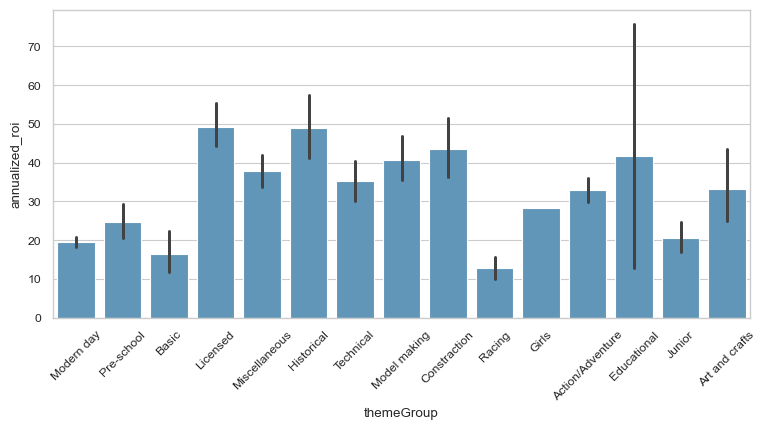

In [151]:
plt.figure(figsize=(9, 4))
sns.barplot(data=df, x='themeGroup', y='annualized_roi', estimator=np.mean, color='#5499c7')
plt.xticks(rotation=45);

Educational (only 1 observation), Historical, Technical and Model making stands out in terms of `annualized_roi`.

**packagingType**

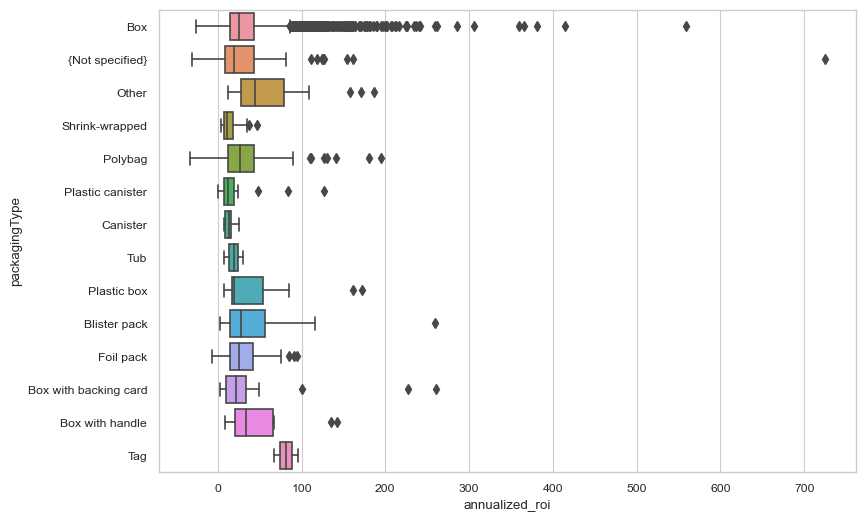

In [152]:
plt.figure(figsize=(9, 6))
sns.boxplot(data=df[df['annualized_roi']<1000], y='packagingType', x='annualized_roi');

They have quite different distributions between dfifferent packaging types. This could indicate a good feature for our model.

**Category**

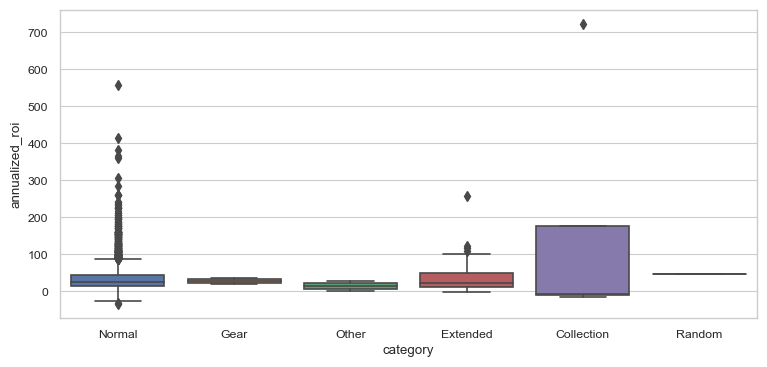

In [153]:
plt.figure(figsize=(9, 4))
sns.boxplot(data=df[df['annualized_roi']<1000], x='category', y='annualized_roi');

**Collection** seems to have higher market value compared to other categories.

In [113]:
df['category'].value_counts()

Normal        3623
Extended        63
Collection       8
Gear             2
Other            2
Random           1
Name: category, dtype: int64

In [121]:
df[(df['theme'].isin(top_10)) & (df['annualized_roi'] < 5000)]

4                     Duplo
5                     Duplo
6                     Duplo
15                Star Wars
16                 Seasonal
               ...         
3685              Star Wars
3687    Marvel Super Heroes
3688    Marvel Super Heroes
3689    Marvel Super Heroes
3698               Seasonal
Name: theme, Length: 2071, dtype: object

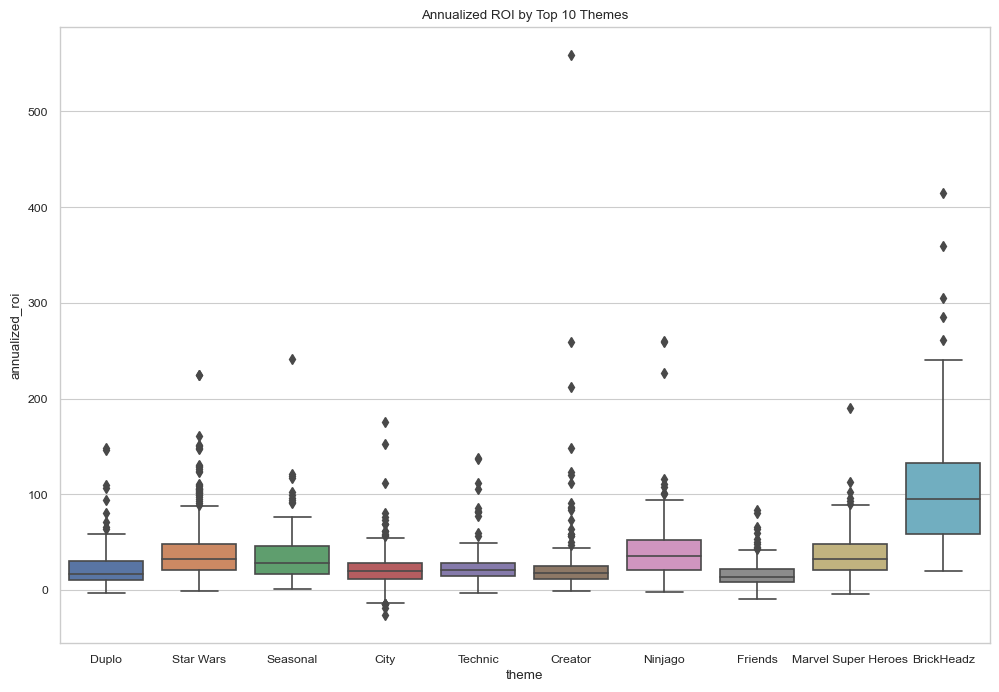

In [124]:
top_10 = df['theme'].value_counts().head(10).index

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[(df['theme'].isin(top_10)) & (df['annualized_roi'] < 5000)], x='theme', y='annualized_roi')
plt.title('Annualized ROI by Top 10 Themes');

## Feature Engineering

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   set_number                  3698 non-null   object 
 1   name                        3698 non-null   object 
 2   year                        3698 non-null   int64  
 3   theme                       3698 non-null   object 
 4   themeGroup                  3698 non-null   object 
 5   subtheme                    3698 non-null   object 
 6   category                    3698 non-null   object 
 7   released                    3698 non-null   bool   
 8   pieces                      3698 non-null   float64
 9   minifigs                    3698 non-null   float64
 10  rating                      3698 non-null   float64
 11  reviewCount                 3698 non-null   int64  
 12  packagingType               3698 non-null   object 
 13  availability                3698 

Since `US_retailPrice` and `pieces` are highly correlated, we can create a new feature `price_per_piece` to reduce the multicollinearity.

In [155]:
df['price_per_piece'] = np.where(df['pieces'] > 0, df['NZ_retailPrice'] / df['pieces'], 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   set_number                  3698 non-null   object 
 1   name                        3698 non-null   object 
 2   year                        3698 non-null   int64  
 3   theme                       3698 non-null   object 
 4   themeGroup                  3698 non-null   object 
 5   subtheme                    3698 non-null   object 
 6   category                    3698 non-null   object 
 7   released                    3698 non-null   bool   
 8   pieces                      3698 non-null   float64
 9   minifigs                    3698 non-null   float64
 10  rating                      3698 non-null   float64
 11  reviewCount                 3698 non-null   int64  
 12  packagingType               3698 non-null   object 
 13  availability                3698 

In [156]:
# Divide by zero?
np.isinf(df['price_per_piece']).sum()

0

In [157]:
df.columns

Index(['set_number', 'name', 'year', 'theme', 'themeGroup', 'subtheme',
       'category', 'released', 'pieces', 'minifigs', 'rating', 'reviewCount',
       'packagingType', 'availability', 'lifespan_days',
       'years_since_last_available', 'NZ_retailPrice', 'market_value',
       'annualized_roi', 'annualized_roi_log', 'rated', 'price_per_piece'],
      dtype='object')

In [158]:
features = ['year', 'theme', 'themeGroup', 'subtheme',
       'category', 'released', 'pieces', 'minifigs', 'rating', 'rated', 'reviewCount',
       'packagingType', 'availability', 'lifespan_days', 'NZ_retailPrice', 'price_per_piece']

df = df[features + ['market_value']]

## Preprocessing

### Encoding categorical features
**Strategy**:
- we will be using **target encoding** as there are high cardinality and imbalance in our categorical features.
- **Target encoding** (also known as mean encoding) is a technique used to encode categorical features by replacing each category with the mean of the target variable for that category. This method captures the relationship between the categorical feature and the target variable, which can be particularly useful when dealing with high cardinality and imbalanced categorical features. 
- Read more on Sci-kit learn documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html#rf862141e5a0c-mic)

**Warning**
- We should only fit the target encoder on the training data and transform both the training and test data (NOT on the entire dataset). This is to prevent data leakage and ensure that the model is not exposed to the target variable in the test data.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, PowerTransformer

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   set_number                  3698 non-null   object 
 1   name                        3698 non-null   object 
 2   year                        3698 non-null   int64  
 3   theme                       3698 non-null   object 
 4   themeGroup                  3698 non-null   object 
 5   subtheme                    3698 non-null   object 
 6   category                    3698 non-null   object 
 7   released                    3698 non-null   bool   
 8   pieces                      3698 non-null   float64
 9   minifigs                    3698 non-null   float64
 10  rating                      3698 non-null   float64
 11  reviewCount                 3698 non-null   int64  
 12  packagingType               3698 non-null   object 
 13  availability                3698 

We will have to deal with negative values of `annualized_roi` to which we cannot apply log transformation. We will use **Yeo-Johnson transformation** to transform the target variable.

In [5]:
pt = PowerTransformer(method='yeo-johnson')

df['annualized_roi_yeojohnson'] = pt.fit_transform(df[['annualized_roi']].values)

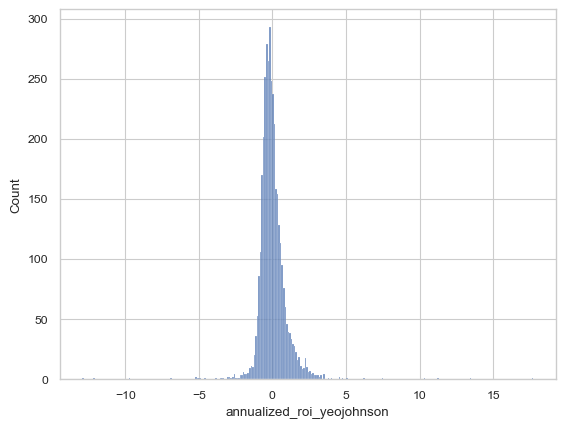

In [6]:
sns.histplot(df['annualized_roi_yeojohnson'], kde=False);

In [7]:
df['annualized_roi_yeojohnson_inverse'] = pt.inverse_transform(df[['annualized_roi_yeojohnson']])

d:\computer programming\anaconda\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


In [8]:
df.head()

,set_number,name,year,theme,themeGroup,subtheme,category,released,pieces,minifigs,...,packagingType,availability,lifespan_days,years_since_last_available,NZ_retailPrice,market_value,annualized_roi,annualized_roi_log,annualized_roi_yeojohnson,annualized_roi_yeojohnson_inverse
0,4515-1,Straight Rails,1991,Trains,Modern day,9V,Normal,True,8.0,0.0,...,Box,Retail,5853,16.810959,22.476688,89.321095,17.690507,2.928016,-0.357215,17.690507
1,4520-1,Curved Rails,1991,Trains,Modern day,9V,Normal,True,8.0,0.0,...,Box,Retail,5853,16.810959,22.476688,61.886554,10.429900,2.436233,-0.622497,10.429900
2,4531-1,Manual Points with Track,1991,Trains,Modern day,9V,Normal,True,6.0,0.0,...,Box,Retail,5853,16.810959,48.431293,78.137416,3.648610,1.536568,-0.949310,3.648610
3,4548-1,Transformer and Speed Regulator,1991,Trains,Modern day,9V,Normal,True,3.0,0.0,...,Box,Retail,5853,16.810959,72.655591,602.373496,43.369371,3.792549,0.338640,43.369371
4,2304-1,Large Building Plate,1992,Duplo,Pre-school,Unknown,Normal,True,1.0,0.0,...,{Not specified},{Not specified},10696,2.526027,27.876558,29.085075,1.716230,0.999245,-1.077074,1.716230


The inverse_transform of the Yeo-Johnson transformation works fine. As the values of untransformed `annualized_roi` and the inverse transformed `annualized_roi_yeojohnson_inverse` are the same.

In [9]:
df.drop(['annualized_roi_yeojohnson_inverse'], axis=1, inplace=True)

## Training models without scalling/ transforming

In [2]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

In [68]:
categorical_cols = df.select_dtypes(include='object').columns[2:]
categorical_cols

Index(['theme', 'themeGroup', 'subtheme', 'category', 'packagingType',
       'availability'],
      dtype='object')

In [69]:
target = 'annualized_roi'
features = ['year', 'theme', 'themeGroup', 'subtheme',
       'category', 'released', 'pieces', 'minifigs', 'rating','rated', 'reviewCount',
       'packagingType', 'availability', 'lifespan_days',
       'years_since_last_available', 'NZ_retailPrice']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
encoder = TargetEncoder(smooth='auto', target_type='continuous')

X_train_encoded = encoder.fit_transform(X_train[categorical_cols], y_train)
X_test_encoded = encoder.transform(X_test[categorical_cols])

In [71]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns=categorical_cols, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=categorical_cols, index=X_test.index)

X_train_rest = X_train.drop(columns=categorical_cols)
X_test_rest = X_test.drop(columns=categorical_cols)

X_train = pd.concat([X_train_encoded, X_train_rest], axis=1)
X_test = pd.concat([X_test_encoded, X_test_rest], axis=1)

### Linear Regression

In [72]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

In [73]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [74]:
print('Simple Linear Regression: ', mse, r2)

Simple Linear Regression:  3105.0338403970404 -0.007684209220556459


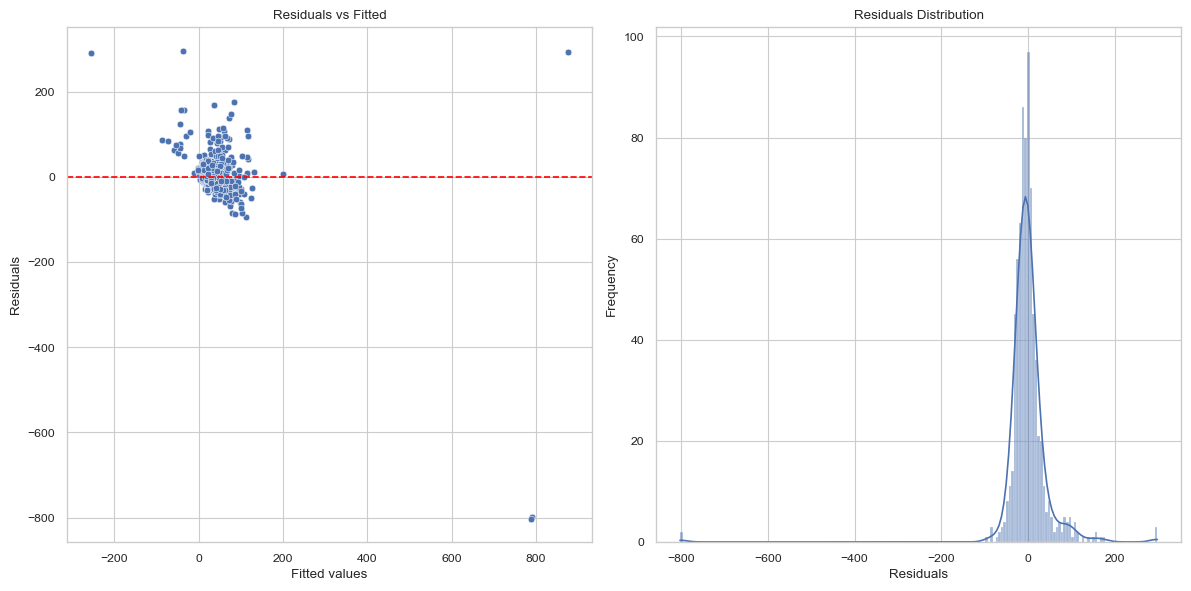

In [75]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(12, 6))

# Residuals vs Fitted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# Q-Q plot
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()

- As values gets higher or lower from zeros. Our model performance decreases.
- This is due to the fact that linear models are sensitive to the scale of the input features (They are all in different scales).
- Presence of outliers in the target variable can also affect the performance of linear models.
- We will try to scale the data (later on) and see if it improves the model performance.
### Trees

In [76]:
dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [77]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Decision Tree: ',mse, r2)

Decision Tree:  4772.863267525214 -0.5489489630937452


In [78]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Random Forest: ',mse, r2)

Random Forest:  2268.2908472612016 0.26386603618711135


In [79]:
gb = GradientBoostingRegressor()

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Gradient Boosting: ',mse, r2)

Gradient Boosting:  2315.1024535851975 0.24867415135570226


### Baseline Model

In [80]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

y_pred = dummy_regr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Dummy Regressor: ',mse, r2)

Dummy Regressor:  3083.0869838133144 -0.0005617422980634945


Good news is our models are performing better than the baseline model. But the performance is still very bad. We will try to transform the target and see if it improves the model performance.

---

In [81]:
pt = PowerTransformer(method='yeo-johnson')

y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))

In [82]:
y_train_transformed.shape, y_test_transformed.shape

((2957, 1), (740, 1))

In [83]:
lm = LinearRegression()
lm.fit(X_train, y_train_transformed)

y_pred_raw = lm.predict(X_test)

y_pred = pt.inverse_transform(y_pred_raw.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Simple Linear Regression: ', mse, r2)

Simple Linear Regression:  1941.8827493921765 0.3697960526993552


In [84]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train_transformed)
y_pred_raw = dt.predict(X_test)
y_red = pt.inverse_transform(y_pred_raw.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Decision Tree: ',mse, r2)

Decision Tree:  1941.8827493921765 0.3697960526993552


In [85]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train_transformed)
y_pred_raw = rf.predict(X_test)
y_pred = pt.inverse_transform(y_pred_raw.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Random Forest: ',mse, r2)

d:\computer programming\anaconda\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest:  1107.9883622478244 0.6404218330533522


In [86]:
gb = GradientBoostingRegressor()

gb.fit(X_train, y_train_transformed)
y_pred_raw = gb.predict(X_test)
y_pred = pt.inverse_transform(y_pred_raw.reshape(-1, 1))

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Gradient Boosting: ',mse, r2)

d:\computer programming\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Gradient Boosting:  982.8921463535365 0.6810196132610553


It looks like transforming the target variables has little impact on the model performance.

### Scaling numerical features

**Strategy**:
- We will use **StandardScaler** to scale the numerical features. This will standardize the data around the mean with a unit standard deviation. This is suitable for algorithms that assume normally distributed data.
- Scikit-learn documentation on StandardScaler [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [87]:
from sklearn.preprocessing import StandardScaler

In [88]:
X_train.head()

,theme,themeGroup,subtheme,category,packagingType,availability,year,released,pieces,minifigs,rating,rated,reviewCount,lifespan_days,years_since_last_available,NZ_retailPrice
2887,37.827211,46.911698,39.171527,35.613507,37.178730,32.332024,2020,True,72.0,1.0,3.8,1,4,378,3.600000,15.382742
2715,113.698721,50.617493,33.695755,35.267557,37.670903,51.363595,2020,True,180.0,0.0,4.0,1,1,387,2.827397,15.382742
818,20.420160,32.682064,16.590709,35.267557,41.226007,33.270968,2013,True,92.0,1.0,3.1,1,1,27,10.731507,18.287080
3560,25.607872,50.161014,17.555505,34.683816,36.840206,32.680404,2022,True,392.0,2.0,4.2,1,0,451,0.630137,47.337176
2578,33.640392,50.617493,28.250770,35.267557,37.670903,33.270968,2019,True,455.0,2.0,4.2,1,3,537,4.161644,60.724255


In [89]:
X_train_noboolean = X_train.drop(columns=['rated', 'released'])
X_test_noboolean = X_test.drop(columns=['rated', 'released'])

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_noboolean)
X_test_scaled = scaler.transform(X_test_noboolean)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_noboolean.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_noboolean.columns, index=X_test.index)

In [90]:
X_train_scaled = pd.concat([X_train_scaled, X_train[['rated', 'released']]], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test[['rated', 'released']]], axis=1)

**Note**: We might need to scale our target variable as well. But for now we will try a few algorithms first and evaluate their performance.

### Target Variable

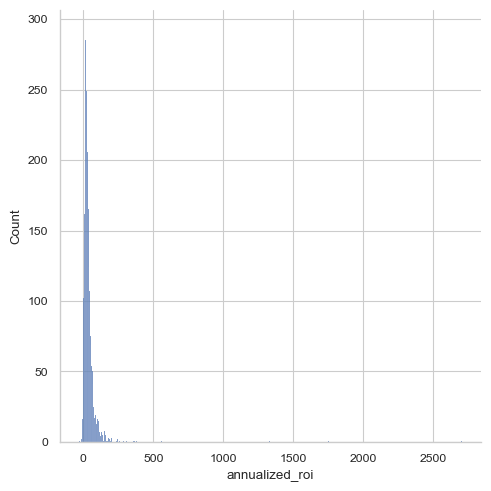

In [91]:
sns.displot(y_train, kde=False);

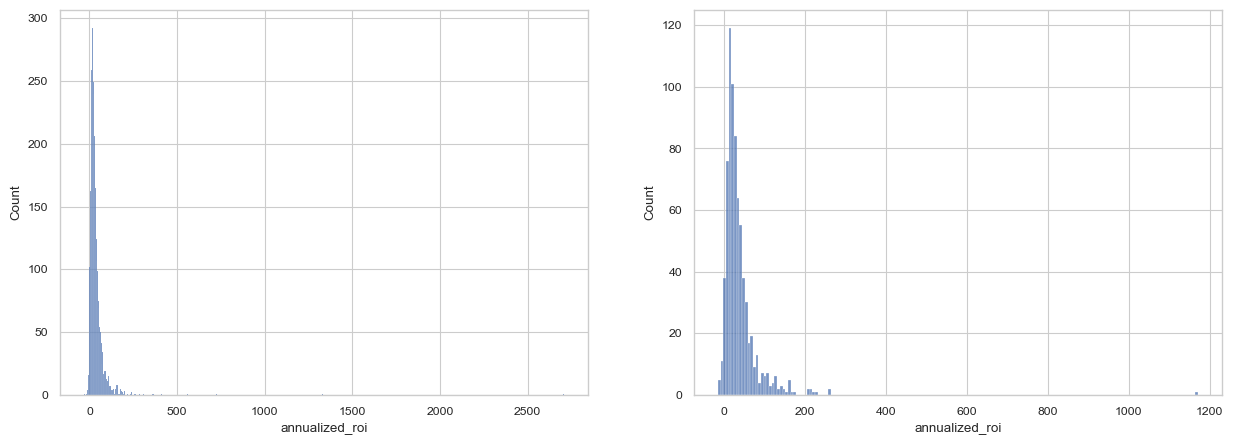

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_train, kde=False, ax=ax[0])
sns.histplot(y_test, kde=False, ax=ax[1]);

In [93]:
#y_train_trans = pd.Series(y_train_transformed.flatten(), index=y_train.index, name='annualized_roi_yeojohnson')
#y_test_trans = pd.Series(y_test_transformed.flatten(), index=y_test.index, name='annualized_roi_yeojohnson')

In [95]:
X_train_scaled

,theme,themeGroup,subtheme,category,packagingType,availability,year,pieces,minifigs,rating,reviewCount,lifespan_days,years_since_last_available,NZ_retailPrice,rated,released
2887,0.112804,0.829030,0.222484,0.299957,0.021494,-0.585973,0.796022,-0.534382,-0.509429,0.305662,0.093890,-0.332850,-0.618649,-0.599029,1,True
2715,3.844823,1.143918,-0.016015,0.120415,0.119395,1.757292,0.796022,-0.373354,-0.856441,0.456352,-0.395187,-0.316641,-0.802039,-0.599029,1,True
818,-0.743426,-0.380088,-0.761031,0.120415,0.826558,-0.470365,-0.784189,-0.504562,-0.509429,-0.221755,-0.395187,-0.964998,1.074126,-0.564053,1,True
3560,-0.488249,1.105131,-0.719009,-0.182535,-0.045843,-0.543079,1.247512,-0.057262,-0.162416,0.607043,-0.558212,-0.201377,-1.323593,-0.214211,1,True
2578,-0.093140,1.143918,-0.253173,0.120415,0.119395,-0.470365,0.570278,0.036671,-0.162416,0.607043,-0.069136,-0.046491,-0.485334,-0.052995,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-0.451742,0.134739,-0.608786,-0.182535,-0.045843,-0.543079,-0.332700,0.264794,-0.856441,0.833078,-0.232161,0.009339,0.356826,0.425160,1,True
1294,-0.985925,0.281454,-1.106005,0.120415,0.119395,-0.470365,-0.332700,-0.556747,-0.509429,0.079626,-0.232161,-0.298631,0.356826,-0.525250,1,True
860,0.961176,1.105131,0.861144,-0.182535,-0.045843,-0.543079,-0.784189,-0.473251,-0.162416,0.456352,1.561120,0.048961,0.808146,-0.593436,1,True
3507,-0.623537,-1.489918,0.152019,-0.027845,0.055736,-0.498267,1.247512,-0.197416,-0.162416,0.154971,0.093890,0.030951,-1.323593,-0.024125,1,True


In [96]:
pd.concat([X_train_scaled, y_train], axis=1).to_csv('train.csv', index=False)
pd.concat([X_test_scaled, y_test], axis=1).to_csv('test.csv', index=False)

----
## Model Building

The metric we will use to evaluate our models is **Mean Absolute Error (MAE)**. It is calculated as the formula below:

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$
Where:
- $y_i$ are the actual values.
- $\hat{y}_i$ are the predicted values.
- $n$ is the number of observations.

The reason we are using MAE is because it is not sensitive to outliers. We would prefer our model to make good predictions overall as the distribution of market price is highly skewed.  It is easier to interpret as it is in the same unit as the target variable.

In [3]:
# A function that takes in a model and returns the MAE and R2 scores

def model_evaluation(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    #y_pred_train = pt.inverse_transform(y_pred_train_raw.reshape(-1, 1))
    #y_pred_test = pt.inverse_transform(y_pred_test_raw.reshape(-1, 1))
    
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    r_squared_train = r2_score(y_train, y_pred_train)
    r_squared_test = r2_score(y_test, y_pred_test)
    
    model_name = model.__class__.__name__
    perfomance = {'Training MAE': mae_train, 'Training R2': r_squared_train,
              'Testing MAE': mae_test, 'Testing R2': r_squared_test}
    
    result = pd.DataFrame(perfomance, index=[model_name])
    return result

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop(['annualized_roi'], axis=1)
X_test = test.drop(['annualized_roi'], axis=1)

y_train = train['annualized_roi']
y_test = test['annualized_roi']

#y_train_transformed = train['annualized_roi_yeojohnson']
#y_test_transformed = test['annualized_roi_yeojohnson']

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2957, 16), (740, 16), (2957,), (740,))

### Some Simple Models

In [100]:
linear_model = LinearRegression()

model_evaluation(linear_model, X_train, y_train, X_test, y_test)

,Training MAE,Training R2,Testing MAE,Testing R2
LinearRegression,24.042944,0.332993,24.44666,-0.007684


In [101]:
dummy_regr = DummyRegressor(strategy='mean')

model_evaluation(dummy_regr,X_train, y_train, X_test, y_test)

,Training MAE,Training R2,Testing MAE,Testing R2
DummyRegressor,26.06785,0.0,26.135402,-0.000562


Well our model is doing better than the baseline model which always predicting the average value of the target variable. However, the perfomance is not that great.

In [102]:
# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_poly = pd.DataFrame(X_train_poly)
X_test_poly = pd.DataFrame(X_test_poly)

In [103]:
poly_model = LinearRegression()
model_evaluation(poly_model, X_train_poly, y_train, X_test_poly, y_test)

,Training MAE,Training R2,Testing MAE,Testing R2
LinearRegression,21.727592,0.730436,27.39463,-2.452375


Polynomial regression (degree 2) provide us with lower training error. However, Test Error decreases indicating overfitting.

### Trying out other models

In [104]:
model_perfomance = pd.DataFrame()
models = [
    LinearRegression(),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(n_estimators=100, max_depth=5),
    GradientBoostingRegressor(n_estimators=100, max_depth=5),
    SVR(kernel='rbf', C=1.0, epsilon=0.1),
    LGBMRegressor(n_estimators=100, max_depth=5)
]

for model in models:
    model_perfomance = model_perfomance.append(model_evaluation(model, X_train, y_train, X_test, y_test))

model_perfomance

C:\Users\truon\AppData\Local\Temp\ipykernel_14104\3102396463.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_perfomance = model_perfomance.append(model_evaluation(model, X_train, y_train, X_test, y_test))
C:\Users\truon\AppData\Local\Temp\ipykernel_14104\3102396463.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_perfomance = model_perfomance.append(model_evaluation(model, X_train, y_train, X_test, y_test))
C:\Users\truon\AppData\Local\Temp\ipykernel_14104\3102396463.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_perfomance = model_perfomance.append(model_evaluation(model, X_train, y_train, X_test, y_test))
C:\Users\truon\AppData\Local\Temp\ipykernel_14104\3102396463.py:12: FutureWarning: Th

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 2957, number of used features: 15
[LightGBM] [Info] Start training from score 37.107942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

C:\Users\truon\AppData\Local\Temp\ipykernel_14104\3102396463.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_perfomance = model_perfomance.append(model_evaluation(model, X_train, y_train, X_test, y_test))
C:\Users\truon\AppData\Local\Temp\ipykernel_14104\3102396463.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_perfomance = model_perfomance.append(model_evaluation(model, X_train, y_train, X_test, y_test))


,Training MAE,Training R2,Testing MAE,Testing R2
LinearRegression,24.042944,0.332993,24.446660,-0.007684
DecisionTreeRegressor,17.552793,0.853664,22.203109,-0.365803
RandomForestRegressor,17.765945,0.790936,21.727435,0.176099
GradientBoostingRegressor,11.372452,0.950483,18.801692,0.015905
SVR,19.925423,0.043478,20.900097,0.064108
LGBMRegressor,17.447005,0.643364,20.983413,0.354451


In [105]:
model_perfomance.sort_values(by='Testing MAE')

,Training MAE,Training R2,Testing MAE,Testing R2
GradientBoostingRegressor,11.372452,0.950483,18.801692,0.015905
SVR,19.925423,0.043478,20.900097,0.064108
LGBMRegressor,17.447005,0.643364,20.983413,0.354451
RandomForestRegressor,17.765945,0.790936,21.727435,0.176099
DecisionTreeRegressor,17.552793,0.853664,22.203109,-0.365803
LinearRegression,24.042944,0.332993,24.446660,-0.007684


In [106]:
model_perfomance.reset_index(names='Model', inplace=True)

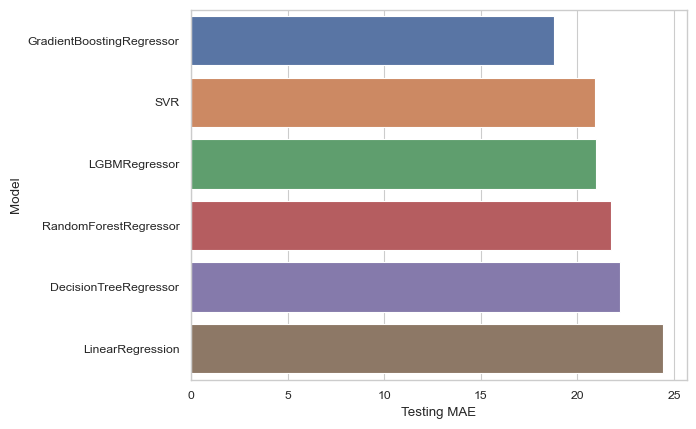

In [107]:
sns.barplot(data=model_perfomance, y='Model', x='Testing MAE', order=model_perfomance.sort_values(by='Testing MAE')['Model']);

Boosting models are by far having the best performance. 

Leading by `GradientBoostingRegressor` with the lowest MAE of 18.8 which means on average our model prediction is off by 18.8% on annualized ROI for a given set.

### Cross Validation

In [108]:
models

[LinearRegression(),
 DecisionTreeRegressor(max_depth=5),
 RandomForestRegressor(max_depth=5),
 GradientBoostingRegressor(max_depth=5),
 SVR(),
 LGBMRegressor(max_depth=5)]

In [11]:
def model_cross_validation(model, X, y, cv=5):
    """Returns the MAE scores of a model using cross-validation"""
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    # Perform cross-validation and get the MAE for each fold
    mae_scores = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer)
    
    # Convert the negative MAE scores to positive
    mae_scores = -mae_scores
    
    return mae_scores

In [110]:
cross_val_df = dict()
for model in models:
    scores = model_cross_validation(model, X_train, y_train, cv=10)
    name = model.__class__.__name__
    cross_val_df[name] = scores

cross_val_df

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1772
[LightGBM] [Info] Number of data points in the train set: 2661, number of used features: 15
[LightGBM] [Info] Start training from score 36.499432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

{'LinearRegression': array([28.30650602, 22.24294919, 31.94888254, 23.38771478, 21.82986168,
        20.67559977, 21.92913569, 20.71740646, 26.7498383 , 24.79680146]),
 'DecisionTreeRegressor': array([21.36419316, 17.54482166, 28.10201456, 18.3864261 , 18.70515396,
        16.2444328 , 17.28392949, 27.17126035, 20.48215655, 20.44239426]),
 'RandomForestRegressor': array([21.22520169, 17.18961377, 27.44597864, 17.78646431, 21.06690881,
        15.97304648, 17.19786528, 22.76945598, 19.33498038, 19.99870866]),
 'GradientBoostingRegressor': array([18.85053138, 16.09954211, 26.19058903, 16.81736845, 20.68100979,
        16.21101912, 16.41608204, 24.31395062, 18.67602915, 18.58958156]),
 'SVR': array([25.72230905, 16.83952328, 26.94802997, 19.15333206, 18.33013474,
        15.87389776, 17.74015895, 18.05204203, 22.78267274, 21.1928606 ]),
 'LGBMRegressor': array([24.10269893, 19.57188984, 25.13143491, 19.70926327, 20.74445929,
        17.01108691, 17.6544082 , 22.62882265, 20.79227364, 20.8

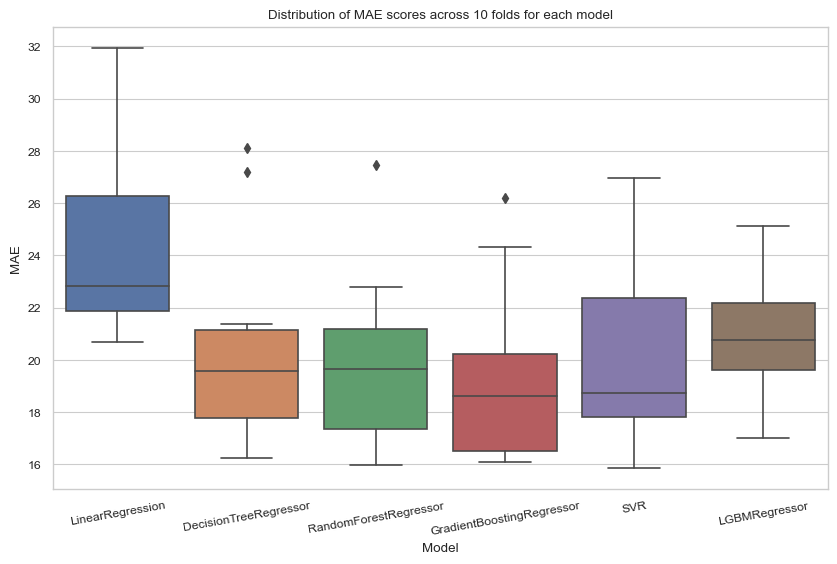

In [112]:
cross_val_df = pd.DataFrame(cross_val_df)
long_df = cross_val_df.melt(var_name='Model', value_name='MAE')

plt.figure(figsize=(10, 6))
sns.boxplot(data=long_df, x='Model', y='MAE')
plt.title('Distribution of MAE scores across 10 folds for each model')
plt.xticks(rotation=10);

The result suggests that Boosting models are performing best followed by Support Vector Regressor and bagging (random forest), Decision Tree and finally Linear Regression.

The two best perfoming models are `LGBMRegressor` and `GradientBoostingRegressor`. Both having low RMSE and low standard deviation.

In [113]:
cross_val_df['LGBMRegressor'].mean(), cross_val_df['LGBMRegressor'].std()

(20.823863240179524, 2.5813063127537617)

In [114]:
cross_val_df['GradientBoostingRegressor'].mean(), cross_val_df['GradientBoostingRegressor'].std()

(19.284570324574087, 3.4942167629801273)

For `GradientBoostingRegressor`, on average, model's prediction if off by ~10.36% from the actual values. The variability of the model is also low - around ~3.11 indicating the model is consistently performing well across different folds.

Try training `GradientBoostingRegressor` using loss function to minimize MAE.

In [115]:
model = GradientBoostingRegressor(max_depth=5, loss='absolute_error')
model.fit(X_train, y_train)

cv_scores = model_cross_validation(model, X_train, y_train, cv=10)
cv_scores

array([22.26150919, 15.29738073, 24.68704397, 15.83649044, 18.31180682,
       14.81974495, 15.62824175, 16.16201795, 18.04090914, 18.26343637])

In [116]:
print(cv_scores.mean(), cv_scores.std())

17.930858130733153 3.0675702018716744


A slight improvement in the model performance. :)

### Feature Importance

In [117]:
model = GradientBoostingRegressor(max_depth=5, random_state=113)
model.fit(X_train, y_train)

feature_importance = model.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [118]:
importance_df

,Feature,Importance
3,category,0.527744
5,availability,0.204421
0,theme,0.063642
12,years_since_last_available,0.049256
2,subtheme,0.042689
11,lifespan_days,0.022653
13,NZ_retailPrice,0.021171
6,year,0.016853
7,pieces,0.014328
1,themeGroup,0.009100


In [119]:
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100

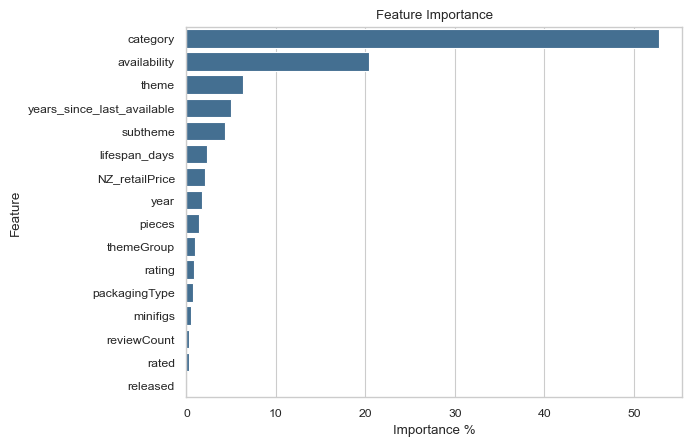

In [120]:
sns.barplot(data=importance_df, x='Importance', y='Feature', color='#37719e')
plt.title('Feature Importance')
plt.xlabel('Importance %')
plt.show()

**Note**: The impurity-based feature importances.

The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

**Warning**: impurity-based feature importances can be misleading for high cardinality features (many unique values). 

We will try to use `sklearn.inspection.permutation_importance` as an alternative.

`Permutation Importance` properties:
>- Model-Agnostic: Can be used with any fitted model.
>- Measures Impact on Performance: Computes the increase in prediction error after permuting the feature values, which directly measures the impact of each feature on the model's performance.
>- Handles High Cardinality Features Better: More robust to high cardinality features as it evaluates the actual impact on the model's predictions.

In [121]:
from sklearn.inspection import permutation_importance

In [129]:
model = GradientBoostingRegressor(max_depth=5, random_state=113, loss='absolute_error')
model.fit(X_train, y_train)

GradientBoostingRegressor(loss='absolute_error', max_depth=5, random_state=113)

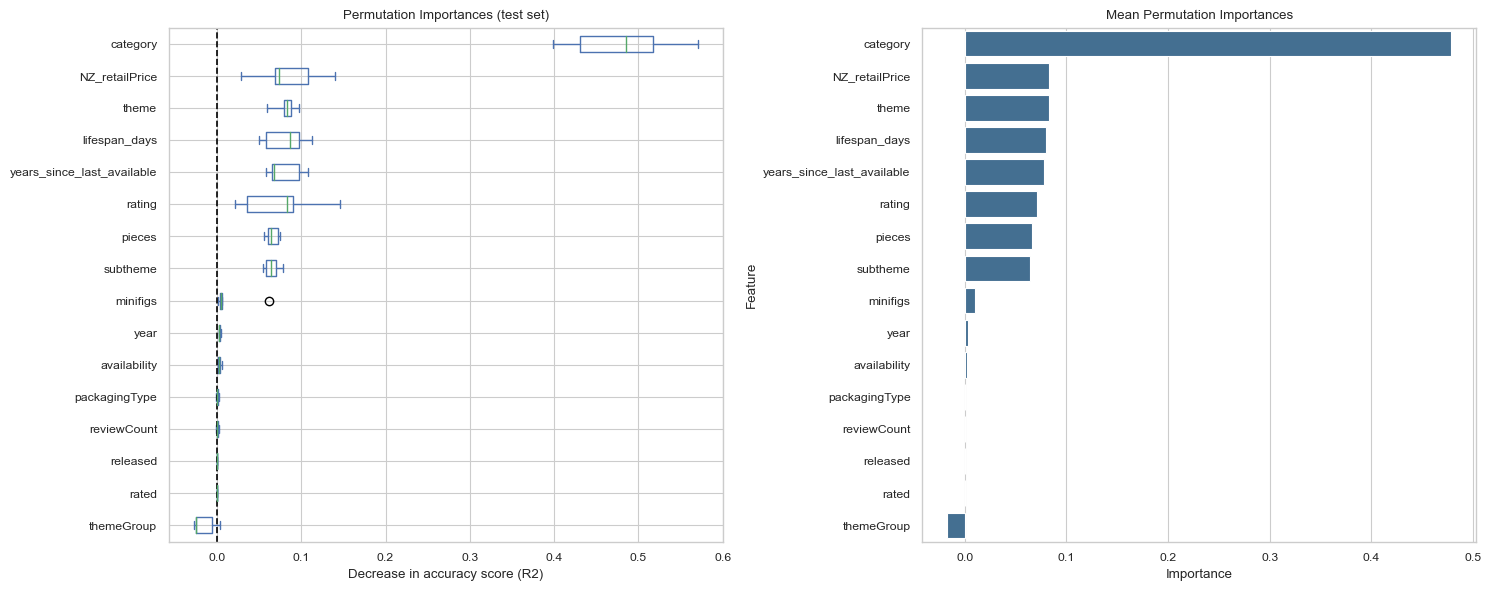

In [130]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=123)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

ax1 = importances.plot.box(vert=False, whis=10, ax=axes[0])
ax1.set_title("Permutation Importances (test set)")
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_xlabel("Decrease in accuracy score (R2)")
ax1.figure.tight_layout()

# Bar plot
perm_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean})
perm_df = perm_df.sort_values(by='Importance', ascending=False)

sns.barplot(data=perm_df, x='Importance', y='Feature', color='#37719e', ax=axes[1]);
axes[1].set_title('Mean Permutation Importances')

plt.tight_layout()
plt.show()

**Observations** 
- The most important feature is indeed `category`. When permuted, the model's performance decreases the most.
- Followed by`NZ_retailPrice`, `theme`, `lifespan_days`, `years_since_last_available`.
- When compared with the Gini importance which suggest that `category` being the most important features - `category` is a high cardinality as seen above --> the permutation importance comfirms that `category` is indeed the most important feature. But this is not the case for `availability`.

Trying excluding `themeGroup`

In [12]:
model = GradientBoostingRegressor(max_depth=5, random_state=421, loss='absolute_error')

X_train_excl_inimportances = X_train.drop(['themeGroup', 'rated', 'released', 'reviewCount', 'packagingType', 'availability'], axis=1)
#model.fit(X_train_excl_themeGroup, y_train)

cv_scores = model_cross_validation(model, X_train_excl_inimportances, y_train, cv=10)
cv_scores

array([22.59115145, 15.12296357, 24.59960495, 15.83374666, 19.23579897,
       14.61859016, 15.83935059, 16.21275713, 19.39976534, 18.43666239])

In [13]:
cv_scores.mean(), cv_scores.std()

(18.18903912236007, 3.1657524069856606)

After excluding the useless features our model is still performing equally well.

### Hyperparameter Tuning
Choosing `GradientBosstingRegressor` as our final model we then proceed to fine tune the hyperparameters. We will use Scikit-learn's GridSearchCV to search for the best hyperparameters.

In [9]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [140]:
model.fit(X_train_excl_inimportances, y_train)

GradientBoostingRegressor(loss='absolute_error', max_depth=5, random_state=421)

The full documentation containing information about the parameters for Gradient Boosting Regressor can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor). 

We will be experimenting with the following hyperparameters:
- `n_estimators`: Default is 100. Number of boosted trees to fit.
- `max_depth`: Maximum depth for base learners. Default is -1 which means no limit. If setting this to a positive value, consider also changing num_leaves to <= 2^max_depth.
- `num_leaves`: Maximum number of leaves for base learners. Default is 31.
- `learning_rate`: Default is 0.1. Boosting learning rate.
- `min_child_samples`: Minimum number of data needed in a child (leaf). Default is 20.


RandomizedSearchCV is used to search for the best hyperparameters. This is a faster method compared to GridSearchCV as it does not try all possible combinations of hyperparameters.

In [141]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting the individual base learners
    'max_features': ['auto', 'sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

In [142]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [143]:
random_search = RandomizedSearchCV(model, param_distributions=param_distributions, scoring=mae_scorer ,n_iter=20, cv=5 , random_state=113)
random_search.fit(X_train_excl_inimportances, y_train)

d:\computer programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "d:\computer programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\computer programming\anaconda\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\computer programming\anaconda\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\compute

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(loss='absolute_error',
                                                       max_depth=5,
                                                       random_state=421),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=113,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'))

In [144]:
best_model = random_search.best_estimator_
best_model

GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                          max_features='log2', min_samples_leaf=4,
                          min_samples_split=5, n_estimators=500,
                          random_state=421)

In [145]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 5,
 'learning_rate': 0.1}

In [8]:
X_test_excl_inimportances = X_test.drop(['themeGroup', 'rated', 'released', 'reviewCount', 'packagingType', 'availability'], axis=1)

In [151]:
y_pred = best_model.predict(X_test_excl_inimportances)
print('Test MAE: ', mean_absolute_error(y_test, y_pred))

Test MAE:  17.686580514615635


In [152]:
print('R squared: ', r2_score(y_test, y_pred))

R squared:  0.6343753881979398


In [153]:
cv_scores = model_cross_validation(best_model, X_train_excl_inimportances, y_train, cv=10)
print('Cross Validation MAE: ', cv_scores.mean(), 'CV std: ', cv_scores.std())

Cross Validation MAE:  17.832341958121077 CV std:  2.7912747289807016


The best model suggested by RandomizedSearchCV gives a test MAE of 17.68 and Cross Validated MAE of 17.83 which is slighly improved from the default model.

**GridSearch** - Exhaustive search over specified parameter values for an estimator. This is computationally expensive and time consuming. We will not try this method unless we have more comuting power.

With the best hyperparameters, we can now build our final model.

In [14]:
final_model = GradientBoostingRegressor(subsample=1.0, n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features='log2', max_depth=5, learning_rate=0.1, random_state=421, loss='absolute_error')
final_model.fit(X_train_excl_inimportances, y_train)

old_model = GradientBoostingRegressor(max_depth=5, random_state=421, loss='absolute_error')
old_model.fit(X_train_excl_inimportances, y_train)

GradientBoostingRegressor(loss='absolute_error', max_depth=5, random_state=421)

In [173]:
final_model_perfomance = model_cross_validation(final_model, X_train_excl_inimportances, y_train, cv=10)
old_model_perfomance = model_cross_validation(old_model, X_train_excl_inimportances, y_train, cv=10)

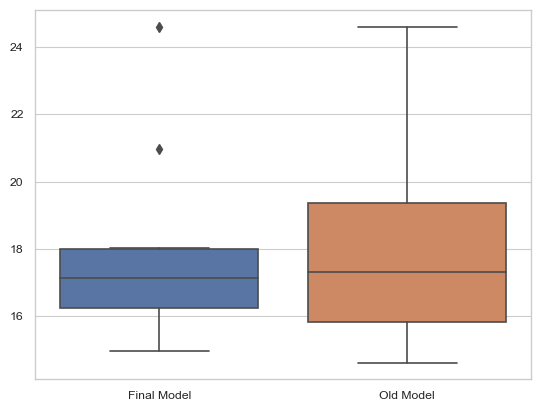

In [182]:
final_model_perfomance = pd.Series(final_model_perfomance, name='Final Model')
old_model_perfomance = pd.Series(old_model_perfomance, name='Old Model')

comparision_df = pd.DataFrame({'Final Model': final_model_perfomance, 'Old Model': old_model_perfomance})

sns.boxplot(data=comparision_df);

Our Tuned Model gives a smaller Average MAE across 10 folds of CV, and also provides less variations - better consistency.

Compare them with different error metrics.

In [15]:
def model_cross_validation(model, X, y, cv=5):
    """Returns the MAE scores of a model using cross-validation"""
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    # Perform cross-validation and get the MAE for each fold
    mae_scores = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer)
    # Convert the negative MAE scores to positive
    mae_scores = -mae_scores
    
    rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    rmse_scores = - rmse_scores
    return mae_scores, rmse_scores

In [16]:
final_model_perfomance = model_cross_validation(final_model, X_train_excl_inimportances, y_train, cv=10)
old_model_perfomance = model_cross_validation(old_model, X_train_excl_inimportances, y_train, cv=10)

d:\computer programming\anaconda\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\computer programming\anaconda\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\computer programming\anaconda\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\computer programming\anaconda\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the r

In [26]:
final_model_perfomance =  pd.Series(final_model_perfomance, name='final_model')
old_model_perfomance = pd.Series(old_model_perfomance, name='old_model')

In [49]:
final_model_perfomance = pd.DataFrame(final_model_perfomance.to_dict())
final_model_perfomance.rename(columns={0: 'mae', 1: 'rmse'}, inplace=True)

old_model_perfomance = pd.DataFrame(old_model_perfomance.to_dict())
old_model_perfomance.rename(columns={0: 'mae', 1: 'rmse'}, inplace=True)

In [54]:
old_model_perfomance['Model'] = 'Old Model'
final_model_perfomance['Model'] = 'New Model'

In [55]:
comparision_df = pd.concat([final_model_perfomance, old_model_perfomance], axis=0)

In [56]:
comparision_df

,mae,rmse,Model
0,20.963815,74.133902,New Model
1,15.066196,24.112658,New Model
2,24.586226,132.962342,New Model
3,16.171700,29.953425,New Model
4,17.754729,34.101584,New Model
5,14.950544,24.269506,New Model
6,16.438195,31.399948,New Model
7,16.496095,29.641026,New Model
8,17.861198,44.403348,New Model
9,18.034722,41.298175,New Model


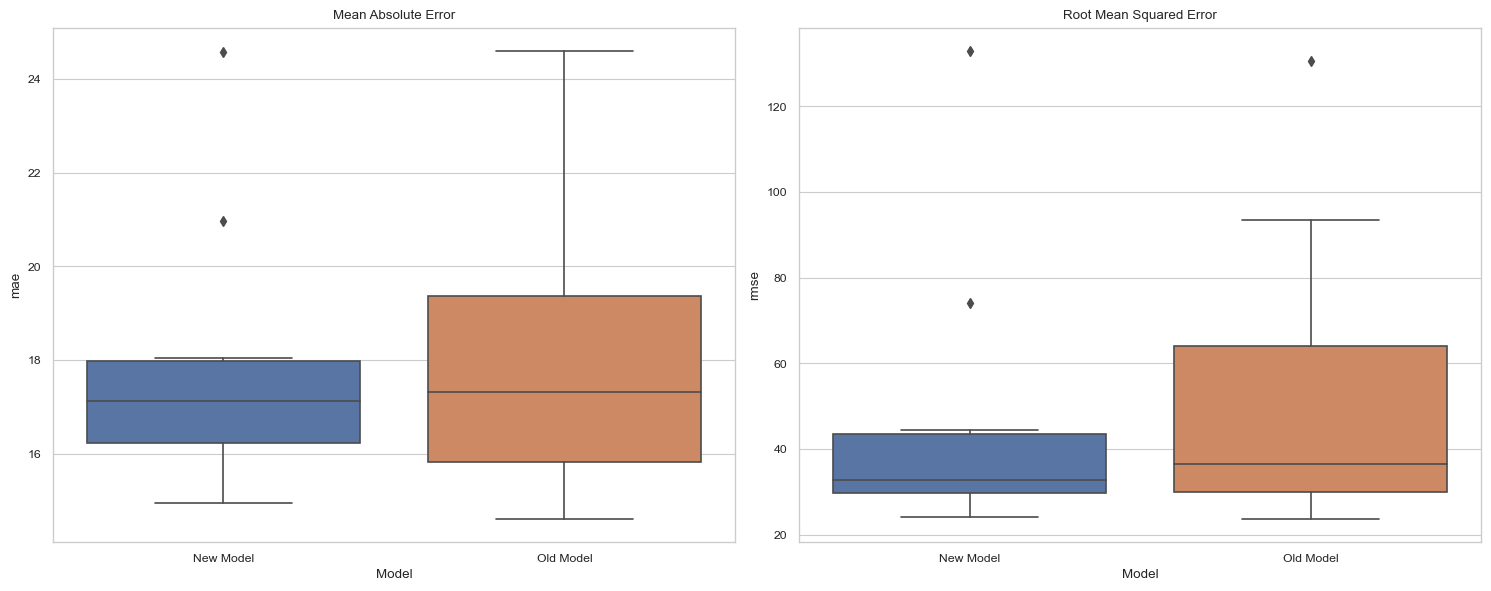

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(y= 'mae', x='Model', data=comparision_df, ax=ax[0])
sns.boxplot(y= 'rmse', x='Model', data=comparision_df, ax=ax[1])

ax[0].set_title('Mean Absolute Error')
ax[1].set_title('Root Mean Squared Error')
plt.tight_layout()

## Pipeline and Model Deployment

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
X_train.drop(['themeGroup', 'rated', 'released', 'reviewCount', 'packagingType', 'availability'], axis=1, inplace=True)
X_train.columns

Index(['theme', 'subtheme', 'category', 'year', 'pieces', 'minifigs', 'rating',
       'lifespan_days', 'years_since_last_available', 'NZ_retailPrice'],
      dtype='object')

In [10]:
numerical_cols = ['year', 'pieces', 'minifigs', 'rating',
       'lifespan_days', 'years_since_last_available', 'NZ_retailPrice']
categorical_cols = ['theme', 'subtheme', 'category']

In [31]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', TargetEncoder(smooth='auto', target_type='continuous')),
    ('scaler', StandardScaler())
])

pipeline  = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )),
    ('model', GradientBoostingRegressor(subsample=1.0, n_estimators=500, min_samples_split=5, 
                                        min_samples_leaf=4, max_features='log2', max_depth=5, 
                                        learning_rate=0.1, random_state=421, loss='absolute_error'))
])

In [32]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'pieces', 'minifigs',
                                                   'rating', 'lifespan_days',
                                                   'years_since_last_available',
                                                   'NZ_retailPrice']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   TargetEncoder(target_type='continuous')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['theme', 'subtheme',
                                                   'category'])])),
                ('model',
                 GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                                           max_features='log2',
                                           min_samples_leaf=4,
                                           min_samples_split=5,
                                           n_estimators=500,
                                           random_state=421))])

In [25]:
new_data = pd.read_csv('D:\study\data309\sets_retiring_soon.csv')
new_data.head()

,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,...,subtheme,minifigs,minifigs_count,current_value_used,current_value_used_high,current_value_used_low,price_events_new,retired,retired_date,price_events_used
0,0,0,0,0,0,0,0.0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,1,1,1,1.0,1,1,1,...,Space,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2,2,2,2,2.0,2,2,2,...,Fairground,"['twn432', 'twn433', 'twn434', 'twn435', 'twn4...",11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,3,3,3,3,3.0,3,3,3,...,Vehicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,4,4,4,4,4.0,4,4,4,...,Licensed,['twn444'],1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
new_data[['set_number', 'year', 'pieces_count', 'released_date', 'retail_price_us', 'theme', 'subtheme', 'minifigs_count', 'retired_date']]

,set_number,year,pieces_count,released_date,retail_price_us,theme,subtheme,minifigs_count,retired_date
0,10274-1,2020,2352,2020-11-16,239.99,Ghostbusters,NaN,NaN,NaN
1,10283-1,2021,2354,2021-04-01,199.99,Icons,Space,NaN,NaN
2,10303-1,2022,3756,2022-07-01,399.99,Icons,Fairground,11.0,NaN
3,10304-1,2022,1456,2022-08-01,169.99,Icons,Vehicles,NaN,NaN
4,10306-1,2022,2532,2022-08-01,239.99,Icons,Licensed,1.0,NaN
...,...,...,...,...,...,...,...,...,...
357,76263-1,2023,66,2023-08-01,26.99,Marvel Super Heroes,Avengers Infinity War,1.0,NaN
358,41744-1,2023,832,2023-06-01,94.99,Friends,Sports,4.0,NaN
359,75308-1,2021,2314,2021-05-01,239.99,Star Wars,NaN,1.0,NaN
360,60375-1,2023,153,2023-01-01,39.99,City,Fire,3.0,NaN


In [27]:
new_data.columns

Index(['Unnamed: 0.17', 'Unnamed: 0.16', 'Unnamed: 0.15', 'Unnamed: 0.14',
       'Unnamed: 0.13', 'Unnamed: 0.12', 'Unnamed: 0.11', 'Unnamed: 0.10',
       'Unnamed: 0.9', 'Unnamed: 0.8', 'Unnamed: 0.7', 'Unnamed: 0.6',
       'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2',
       'Unnamed: 0.1', 'Unnamed: 0', 'availability', 'currency',
       'current_value_new', 'ean', 'forecast_value_new_2_years',
       'forecast_value_new_5_years', 'name', 'pieces_count', 'released_date',
       'retail_price_au', 'retail_price_ca', 'retail_price_eu',
       'retail_price_uk', 'retail_price_us', 'set_number', 'theme', 'upc',
       'year', 'subtheme', 'minifigs', 'minifigs_count', 'current_value_used',
       'current_value_used_high', 'current_value_used_low', 'price_events_new',
       'retired', 'retired_date', 'price_events_used'],
      dtype='object')